# Modeling with the derivative of AVA activity:
(written by Amanda Ray for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Written: 04.08.25, Last updated: 10.21.25


This code will walk through how we model AIB activity using the derivative of AVA (dAVA/dt) to represent a change in reversal activity. We will be convolving the amplitudes of AWC and AIA kernels so that they are being fit to dAVA. We also include an offset term due to the differences in AWC and AIA amplitudes with dAVA/dt. WT modeling will be shown as an example. How to apply models to ignore/silence models will also be explained. 


** Please note that I am an amateur at coding. I'm sure there are more efficient ways to code things, so please feel free to rewrite code more proficiently for your own usage! :) **

In [1]:
## Imports ##

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy
import math
import statistics
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

In [4]:
## Importing Dictionary Datasets ##

# Worm numbers
WT_worm_num = 15
WT_AWC_worm_num = 20
nmrHis_worm_num = 20
insHis_worm_num = 12
strHis_worm_num = 14

# All datasets include odor, red light, and odor + red light (nicknamed 'both') experiments for each neuron.

# AVA-AIB-AIA traces for WT worms - 15 worms #
WT_dict = np.load('WT AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(WT_dict)

# AWC traces for WT worms - 20 worms #
WT_AWC_dict = np.load('WT AWC.npy', allow_pickle=True).item()
#print(WT_AWC_dict)

# AVA-AIB-AIA traces for nmr-1::HisCl (motor-silenced) worms - 20 worms #
nmrHis_dict = np.load('nmr-1_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(nmrHis_dict)

# AVA-AIB-AIA traces for str-2::HisCl (AWC-silenced) worms - 14 worms #
strHis_dict = np.load('str-2_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(strHis_dict)

# AVA-AIB-AIA traces for ins-1s::HisCl (AIA-silenced) worms - 12 worms #
insHis_dict = np.load('ins-1s_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(insHis_dict)

print("Imported data successfully!")

#--------------#
# Also import relevant single neuron convolution parameters obtained from 
# 'Modeling Neuron Data - Single Neuron Convolution.ipynb'
# Here, we will just use the median WT AVA-Only alpha 1&2 parameters.

WT_AVA_only_params = np.load('WT AVA Only Param Medians.npy', allow_pickle=True).item()

# We also need the amplitudes of AVA that resulted from the summation models
# ('Modeling Neuron Data - Summation.ipynb')
WT_sum_amps = np.load('WT Sum Amps.npy', allow_pickle=True).item()

ignored_sum_amps = np.load('Ignored Sum Amps.npy', allow_pickle=True).item()

silenced_sum_amps = np.load('Silenced Sum Amps.npy', allow_pickle=True).item()


Imported data successfully!


In [5]:
# Find and return data arrays of interest for each worm, type of trace (raw, background corrected, or normalized), 
# and experiment (odor, red light, odor+red [both]). 

def FindNeurons(dictionary, data_type, neuron_name, exp):
    
    array = []
    
    for key, value in dictionary.items(): # this loops through worms and types of traces
        for key2, value2 in value.items(): # for each worm, loops through the types of data to get arrays
            if data_type in key and neuron_name in key2 and exp in key2:
                array.append(value2)
                
    if not array: # Check if correct array exists, otherwise will be empty
        print("Error! Does not exist! Make sure you are in correct dictionary and using correct keywords!")
    else:       
        return array


# Pull out full set of experiments for AIB, AVA, AIA, and AWC - just showing WT for simplicity
# We will use normalized data, and will only use odor + red light ('both') data for demonstration, but the other
# experiments will be needed for ignoring/silencing models

WT_AIB_odor = FindNeurons(WT_dict, "Norm", "AIB", "Odor")
WT_AIB_red = FindNeurons(WT_dict, "Norm", "AIB", "Red")
WT_AIB_both = FindNeurons(WT_dict, "Norm", "AIB", "Both")

WT_AVA_odor = FindNeurons(WT_dict, "Norm", "AVA", "Odor")
WT_AVA_red = FindNeurons(WT_dict, "Norm", "AVA", "Red")
WT_AVA_both = FindNeurons(WT_dict, "Norm", "AVA", "Both")

WT_AIA_odor = FindNeurons(WT_dict, "Norm", "AIA", "Odor")
WT_AIA_red = FindNeurons(WT_dict, "Norm", "AIA", "Red")
WT_AIA_both = FindNeurons(WT_dict, "Norm", "AIA", "Both")

WT_AWC_odor = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Odor")
WT_AWC_red = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Red")
WT_AWC_both = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Both")

# NOTE: Since AWC recordings were performed in a separate worm and do not correlate with the same worm recordings
# with AVA-AIB-AIA worms, we will actually use the averaged traces of AWC for each experiment as a representative
# of AWC activity for modeling. Then we're going to duplicate it to make looping through easier for modeling. 
# This is useful mostly for being able to switch the order of AWC during ignoring and silencing exps.
# I duplicated it by 20 because that's the largest number of worms I have in the datasets (motor-silenced=20)
WT_AWC_odor_avg = np.mean(WT_AWC_odor, axis=0)
WT_AWC_red_avg = np.mean(WT_AWC_red, axis=0)
WT_AWC_both_avg = np.mean(WT_AWC_both, axis=0)

WT_AWC_odor_avg = [WT_AWC_odor_avg]*20 
WT_AWC_red_avg = [WT_AWC_red_avg]*20
WT_AWC_both_avg = [WT_AWC_both_avg]*20


# Silencing Data #

# Motor-silenced (nmr-1::HisCl):
# For modeling, we only need the odor+red light (both) exps. Also note we only need to pull out
# AIB and AIA data since AVA data is silenced, and we use WT_AWC_both_avg data for AWC.
nmrHis_AIB_both = FindNeurons(nmrHis_dict, "Norm", "AIB", "Both")

nmrHis_AIA_both = FindNeurons(nmrHis_dict, "Norm", "AIA", "Both")


# AWC-silenced:
# For modeling, we only need the red-light experiments to activate AIA since AWC is silenced. 
strHis_AIB_red = FindNeurons(strHis_dict, "Norm", "AIB", "Red")

strHis_AVA_red = FindNeurons(strHis_dict, "Norm", "AVA", "Red")

strHis_AIA_red = FindNeurons(strHis_dict, "Norm", "AIA", "Red")


# AIA-silenced:
# For modeling, we only need the odor experiments to activate AWC since AIA is silenced. Also note
# we only need to pull out AIB and AVA data since AIA is silenced, and we use WT_AWC_odor_avg data for AWC.
insHis_AIB_odor = FindNeurons(insHis_dict, "Norm", "AIB", "Odor")

insHis_AVA_odor = FindNeurons(insHis_dict, "Norm", "AVA", "Odor")

print('Done')

Done


In [6]:
# Taking the derivative of AVA # 

# This takes AVA data and shifts the beginnings and end by a certain number of frames (we found 10 to be
# sufficient), then take the difference between the shifted data and divide it by shift x 2

# This will represent the change in reversal (AVA) activity.

# NOTE: since we are shifting the dataset at the beginning and end, this truncates the data. This is important for
# subsequent modeling and plotting so remember this! 

def Derivative(array, shift):

    der = []

    for i in array:

        xminus = i[:-shift]
        xminus = np.insert(xminus, 0, [np.nan]*(shift)) # add nans to beginning

        xplus = i[shift:]
        xplus = np.append(xplus, [np.nan]*(shift)) # add nans to end

        dxdt_temp = (xplus - xminus) / (2*shift) # divide by shift x 2
        dxdt_temp_cut = dxdt_temp[shift:-shift] # cut off nans at beginning and end
        der.append(dxdt_temp_cut)
        
    return der

WT_dAVA_both = Derivative(WT_AVA_both, 10)

# Also need to take derivative of AVA in silenced datasets (not nmrHis since it has no AVA activity)
insHis_dAVA_odor = Derivative(insHis_AVA_odor, 10)

strHis_dAVA_red = Derivative(strHis_AVA_red, 10)

print('Done')


Done


In [7]:
## - Model AIB data by using the derivative of AVA activity - ##

# Method uses downhill simplex method (Nelder-Mead) via scipy optimize to find the smallest residual between 
# model and real AIB. Need to seed the function first with some parameters (params) to help find optimum solution. 
# Due to similarity in alpha 1/2 values in kernels (see 'Modeling Neuron Data - Single Neuron Convolution.ipynb'
# code for details), we use the same fixed values, which are the median values from AVA-only modeling. 
# We also re-use the AVA amplitude values (obtained from the summation model, see 'Modeling Neuron Data - Summation.ipynb')
# for each worm, since AVA will not need to be refit. 

# This function will take the above AVA kernel and add it to AWC and AIA kernels which undergo a nested convolution
# where their amplitudes are being fit to the derivative of AVA (dAVA). We also add an offset term since the AWC/AIA 
# amplitudes are different in scale to dAVA/dt. 


# AVA will usually be present and inputed first when using this model (except for supp. fig 4 block below)
# but the other two will be interchangeable for ignore/silence modeling. 
# If only one neuron is used, input neuron2 as 'BLANK'
def Convolution_Derivative(AIB, AVA, neuron1, neuron2, AVA_amp, alpha1_input, alpha2_input, dAVA, params, worm_num):
    time = 250 # kernel time window, we found 250 frames to be a good time period
    t = np.arange(0, time)
    
    shift = 10 # remember that the derivative of AVA is truncated, need to match other neuron data during fitting
    
    models = [] 
    res = [] 
    neuron1_amp = []
    neuron1_offset = []
    neuron2_amp = []
    neuron2_offset = []
    
    def Model(AVA, neuron1, neuron2, AVA_amp, alpha1_input, alpha2_input, dAVA, params):
        amp1 = params[0]
        offset1 = params[1]
        
        kernel_min = (np.exp(-alpha1_input*t) - np.exp(-alpha2_input*t))
        
        kernelAVA = AVA_amp * kernel_min
        
        kernel1 = amp1 * kernel_min # neuron1 kernel
        dava_amp1 = np.convolve(dAVA, kernel1, 'same') + offset1 # convolve neuron1 kernel with dAVA
        # use the 'same' method which doesn't truncate data. Use this new amplitude to fit for model
        
        if neuron2 == 'BLANK':
            model = np.convolve(AVA[shift:-shift], kernelAVA, 'valid') + np.convolve(neuron1[shift:-shift] * dava_amp1, kernel_min, 'valid')
        
        else:
            amp2 = params[2]
            offset2 = params[3]
            
            kernel2 = amp2 * kernel_min
            dava_amp2 = np.convolve(dAVA, kernel2, 'same') + offset2 
            
            model = np.convolve(AVA[shift:-shift], kernelAVA, 'valid') + np.convolve(neuron1[shift:-shift] * dava_amp1, kernel_min, 'valid') + np.convolve(neuron2[shift:-shift] * dava_amp2, kernel_min, 'valid')
        # 'valid' method produces convolution where the beginning of the original trace is lost.
        # Loss is calculated by time window used (250) minus 1, so that resulting model is 249 frames less than 
        # original. This becomes important for plotting later to properly align model with original traces.
        
        return model
        
    for i in range(worm_num):
        #print('Worm #: ', i) # can uncomment to show progress
        def Res(params):
            if neuron2 == 'BLANK':
                model_AIB = Model(AVA[i], neuron1[i], 'BLANK', AVA_amp[i], alpha1_input, alpha2_input, dAVA[i], params)
            else:
                model_AIB = Model(AVA[i], neuron1[i], neuron2[i], AVA_amp[i], alpha1_input, alpha2_input, dAVA[i], params)
            
            loss = time - 1 + shift # this is from convolution loss (see comment above)
            # to align real AIB with model, we have to cut off the loss in the beginning (AIB[i][loss:])
            # make sure to add shift to match with dAVA length
            
            # Residual:
            # take difference of real vs model AIB, square it, divide it by number of frames, then take square root
            Residual = np.sqrt(np.sum(np.subtract(AIB[i][loss:-shift],model_AIB)**2) / len(model_AIB))
            return Residual
        

        optimize = minimize(Res, params, method='Nelder-Mead') # optimizing for smallest solution (residual)
        res.append(optimize['fun']) # want to save resulting residual
        parameters_new = optimize['x'] # final new parameters based on optimization
        neuron1_amp.append(parameters_new[0])
        neuron1_offset.append(parameters_new[1])
        if neuron2 == 'BLANK':
            new_model = Model(AVA[i], neuron1[i], 'BLANK', AVA_amp[i], alpha1_input, alpha2_input, dAVA[i], parameters_new)
        else:
            neuron2_amp.append(parameters_new[2])
            neuron2_offset.append(parameters_new[3])
            new_model = Model(AVA[i], neuron1[i], neuron2[i], AVA_amp[i], alpha1_input, alpha2_input, dAVA[i], parameters_new)
        models.append(new_model) # save resulting model

    return res, models, neuron1_amp, neuron1_offset, neuron2_amp, neuron2_offset

p_dx = [1, 0.1, -1, 0.1] # * change so that AIA is seeded with -1 in silence/ignore scenarios
p_dx_plus = [1, 0.1, 1, 0.1]
p_dx_minus = [-1, 0.1, -1, 0.1] # *
# Note these are slightly different seeds than previous models. Just helps AIA modeling a little better if
# it is seeded with -1. Feel free to use same seed (0.09) as before, output is identical.
# Parameters used for seeding initial optimization. Order corresponds to order of neurons (amp, offset for each neuron)
# These were determined through a series of tests. Seeded values too far off can sometimes result in the 
# model getting stuck in local minima. Feel free to try others. AIA works well with more negative numbers. 

# Note in the paper, the seeds I used had extra values, initially for trying to fit to alpha values before we 
# realized we could use the same fixed alpha values. I eventually changed the code to keep the alphas fixed,
# but the extra seed values remained. Scipy minimize still tries to "fit" these params even though they're not
# actually used in the models for whatever reason. The difference is negligible, but the values are slightly 
# different here (which is more cleaned up) vs the paper. The difference is off by 1x10-5 to 1x10-4 (very small).
# Just mentioning for transparency.
# Try seeding with this to test for yourself to see how small the difference is:
# seed I used = [1, 0.1, -1, 0.1, 0.01, 0.02, 0.01, 0.02] where 0.01 is for alpha 1, 0.02 is for alpha2,
# but we don't actually fit these parameters (only fitting param index: 0-3)

# I will only show WT modeling here, and I'm using odor+red light (both) experiments for full AWC and AIA
# activation for modeling. Other versions of models see below.

## WT - AVA + dAVA(AWC+AIA) ##

WT_dx = Convolution_Derivative(WT_AIB_both, WT_AVA_both, WT_AWC_both_avg, WT_AIA_both, WT_sum_amps['AVA Amp'],
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   WT_dAVA_both, p_dx, WT_worm_num)
WT_dx_res = WT_dx[0]
WT_dx_models = WT_dx[1]
WT_dx_AWC_amp = WT_dx[2]
WT_dx_AWC_offset = WT_dx[3]
WT_dx_AIA_amp = WT_dx[4]
WT_dx_AIA_offset = WT_dx[5]

print('WT: done')

# - Save Residual - #
np.save('WT Derivative Residual.npy', WT_dx_res)

WT_dx_params = {'AWC Amp':WT_dx_AWC_amp, 'AIA Amp':WT_dx_AIA_amp, 'AWC Offset':WT_dx_AWC_offset, 'AIA Offset':WT_dx_AIA_offset}                                                
np.save('WT Dx Params.npy', WT_dx_params)


/var/folders/h2/nr_g6r3s37v0y4h9l4yjz0bw0000gn/T/ipykernel_58313/2331359903.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if neuron2 == 'BLANK':


WT: done


In [26]:
## Ignore Models ##

# For ignore models, want to use odor+red light (both) exps for maximum neuron activity. 
# I also used the same full WT AVA+AWC+AIA AVA amplitude, but you can replace with corresponding ignored AVA amp
# to be more specific. The outputs are similar. 

# Note we can't apply the derivative model to scenarios where AVA is ignored/silence, since the model relies on
# the derivative of AVA.

# ignore AWC: AVA + dAVA(AIA)
WT_iAWC_dx = Convolution_Derivative(WT_AIB_both, WT_AVA_both, WT_AIA_both, 'BLANK', WT_sum_amps['AVA Amp'],
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   WT_dAVA_both, p_dx_minus, WT_worm_num)
WT_iAWC_dx_res = WT_iAWC_dx[0]
WT_iAWC_dx_models = WT_iAWC_dx[1]
WT_iAWC_dx_AIA_amp = WT_iAWC_dx[2]
WT_iAWC_dx_AIA_offset = WT_iAWC_dx[3]


# ignore AIA: AVA + dAVA(AWC)
WT_iAIA_dx = Convolution_Derivative(WT_AIB_both, WT_AVA_both, WT_AWC_both_avg, 'BLANK', WT_sum_amps['AVA Amp'],
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   WT_dAVA_both, p_dx_plus, WT_worm_num)
WT_iAIA_dx_res = WT_iAIA_dx[0]
WT_iAIA_dx_models = WT_iAIA_dx[1]
WT_iAIA_dx_AWC_amp = WT_iAIA_dx[2]
WT_iAIA_dx_AWC_offset = WT_iAIA_dx[3]

print('WT (ignore): done')


WT (ignore): done


In [30]:
## Silence ##

# Note that even though we use diff experiments for silencing, we still use the same WT AVA-only alpha1/2
# parameters from 'both' exp because they are similar. Feel free to use respective experiment's parameters instead.

# AWC silenced/inactive - use red light exps to only activate AIA. # 
noAWC_dx = Convolution_Derivative(strHis_AIB_red, strHis_AVA_red, strHis_AIA_red, 'BLANK', silenced_sum_amps['noAWC-AVA Amp'],
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   strHis_dAVA_red, p_dx_minus, strHis_worm_num)
noAWC_dx_res = noAWC_dx[0]
noAWC_dx_models = noAWC_dx[1]
noAWC_dx_AIA_amp = noAWC_dx[2]
noAWC_dx_AIA_offset = noAWC_dx[3]
 

# AIA silenced - use odor exps to activate AWC. #
# Note that you will need to apply the single-neuron model in ins-1s_hiscl dataset for an AVA-only model to
# obtain new AVA-only alpha parameters (even though it is identical to WT alpha values).
# Note that we use the same WT AWC activity. 
noAIA_dx = Convolution_Derivative(insHis_AIB_odor, insHis_AVA_odor, WT_AWC_odor_avg, 'BLANK', silenced_sum_amps['noAIA-AVA Amp'],
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   insHis_dAVA_odor, p_dx_plus, insHis_worm_num) 
noAIA_dx_res = noAIA_dx[0]
noAIA_dx_models = noAIA_dx[1]
noAIA_dx_AWC_amp = noAIA_dx[2]
noAIA_dx_AWC_offset = noAIA_dx[3]

print('Silencing: done')

Silencing: done


In [22]:
## Supplemental Figure 4 - Alternative Derivative Models ##

# Note I'm basically putting AVA input twice (adding it with itself), just so I don't have to modify the 
# convolution code above
WT_dAVA_alt = Convolution_Derivative(WT_AIB_both, WT_AVA_both, WT_AVA_both, 'BLANK', WT_sum_amps['AVA Amp'],
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   WT_dAVA_both, p_dx_plus, WT_worm_num) 
WT_dAVA_res = WT_dAVA_alt[0]
WT_dAVA_models = WT_dAVA_alt[1]
WT_dAVA_amp = WT_dAVA_alt[2]
WT_dAVA_offset = WT_dAVA_alt[3]


# Note the order of inputs; swapping AWC or AIA with AVA's place

WT_dAWC_both = Derivative(WT_AWC_both_avg, 10)

WT_dAWC_alt = Convolution_Derivative(WT_AIB_both, WT_AWC_both_avg, WT_AVA_both, 'BLANK', WT_sum_amps['AWC Amp'],
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   WT_dAWC_both, p_dx_plus, WT_worm_num) 
WT_dAWC_res = WT_dAWC_alt[0]
WT_dAWC_models = WT_dAWC_alt[1]
WT_dAWC_amp = WT_dAWC_alt[2]
WT_dAWC_offset = WT_dAWC_alt[3]


WT_dAIA_both = Derivative(WT_AIA_both, 10)

WT_dAIA_alt = Convolution_Derivative(WT_AIB_both, WT_AIA_both, WT_AVA_both, 'BLANK', WT_sum_amps['AIA Amp'],
                               WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], 
                                   WT_dAIA_both, p_dx_minus, WT_worm_num) 
WT_dAIA_res = WT_dAIA_alt[0]
WT_dAIA_models = WT_dAIA_alt[1]
WT_dAIA_amp = WT_dAIA_alt[2]
WT_dAIA_offset = WT_dAIA_alt[3]

print('Alt models: Done')


Alt models: Done


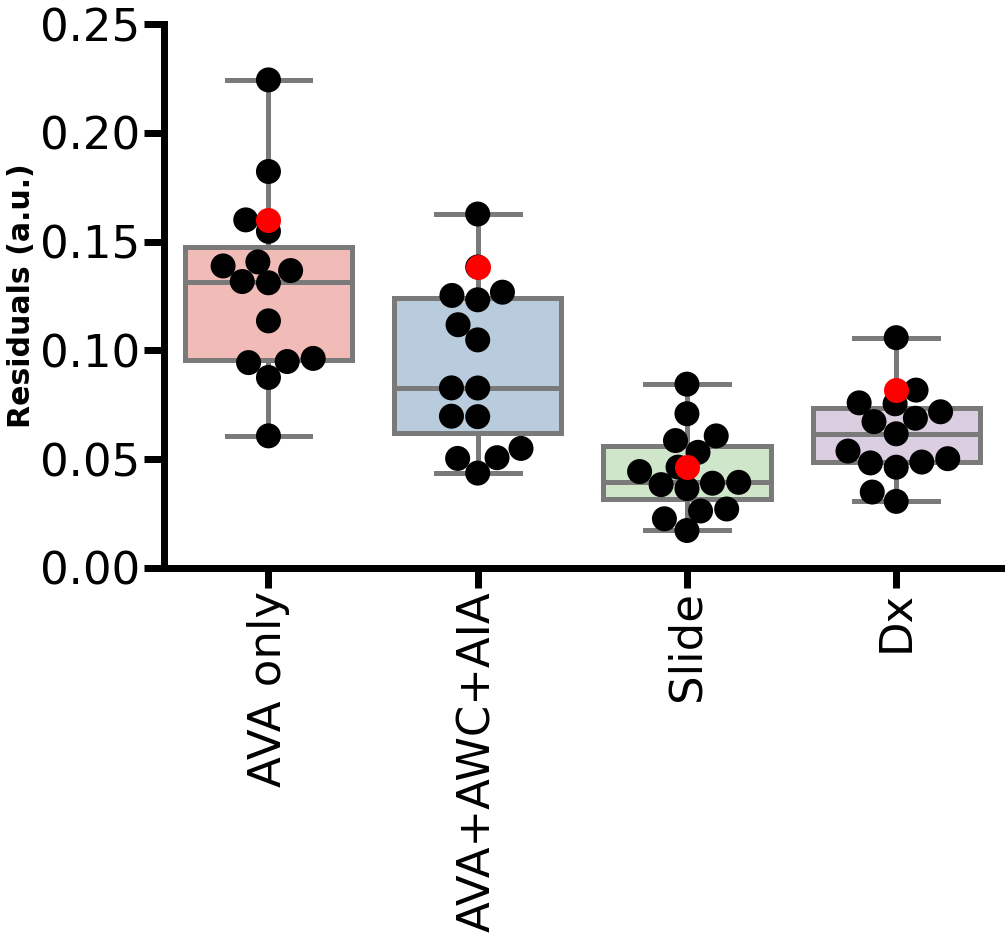

In [19]:
## Plotting Residuals for Comparison ##
# Just showing WT ignored models for simplicity 

# Import previously saved AVA-only residuals from previous modeling 
# (see 'Modeling Neuron Data - Single Neuron Convolution.ipynb' code)
# allow_pickle=True).item() needed for items with multiple elements (ie 2D arrays)
WT_AVA_only_res = np.load('WT AVA Only Residuals.npy', allow_pickle=True).item()

# Import previously saved AVA+AWC+AIA residuals from previous modeling 
# (see 'Modeling Neuron Data - Summation.ipynb' code)
# pickle not needed for lists
WT_sum_res = np.load('WT Sum Residual.npy')

# Import previously saved AVA+AWC+AIA residuals from previous modeling 
# (see 'Modeling Neuron Data - Summation.ipynb' code)
WT_slide_res = np.load('WT Slide Residual.npy')

data = np.array([ WT_AVA_only_res['Residual Both'], WT_sum_res, WT_slide_res, WT_dx_res ])
labels = ['AVA only','AVA+AWC+AIA', 'Slide', 'Dx']

dF_sum = pd.DataFrame(data.T, columns=labels)

colors = sns.color_palette("Pastel1")

fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 7
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
sns.boxplot(data=dF_sum, linewidth = 5, palette = colors)
sns.swarmplot(data=dF_sum, size=25, color = 'black')
sns.swarmplot(data=dF_sum.loc[[2]], size=25, color='red') 
# this is to highlight specific trace shown throughout
# note that this duplicates datapoint, so I just use it to highlight the datapoint
plt.xticks(rotation=90)
ax.set_ylim([0,0.25])
ax.set_ylabel('Residuals (a.u.)', fontsize=30, weight='bold')
ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)


    AWC (full)  AWC (iAIA)  AWC (-AIA)  AIA (full)  AIA (iAWC)  AIA (-AWC)
0     0.314650    0.202560    0.071142   -0.061834    0.092113    0.010458
1     0.614463    0.149467    0.082196   -0.208061    0.053765    0.042601
2     0.235541    0.098068    0.082783   -0.185811    0.134020    0.006854
3     0.107226    0.083968    0.413698   -0.025270    0.162876   -0.026135
4     0.452239   -0.103002    0.048458   -0.608603    0.384558    0.011035
5     0.039216    0.089052    0.001632   -0.010132    0.019181   -0.049091
6    -0.327270    0.202473    0.019022    2.320144    1.742267    0.089530
7    -0.028823   -0.035400    0.002953    0.013266   -0.007221    0.013364
8     0.171883    0.112421    0.064339   -0.082413    0.131409    0.010102
9     0.221561    0.124157    0.053728   -0.036122    0.042675    0.005545
10    0.296849    0.186724   -0.030859   -0.064499    0.075312    0.016314
11    0.210774    0.088249   -0.002104   -0.059668    0.041285   -0.007500
12    0.068038    0.09248

/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


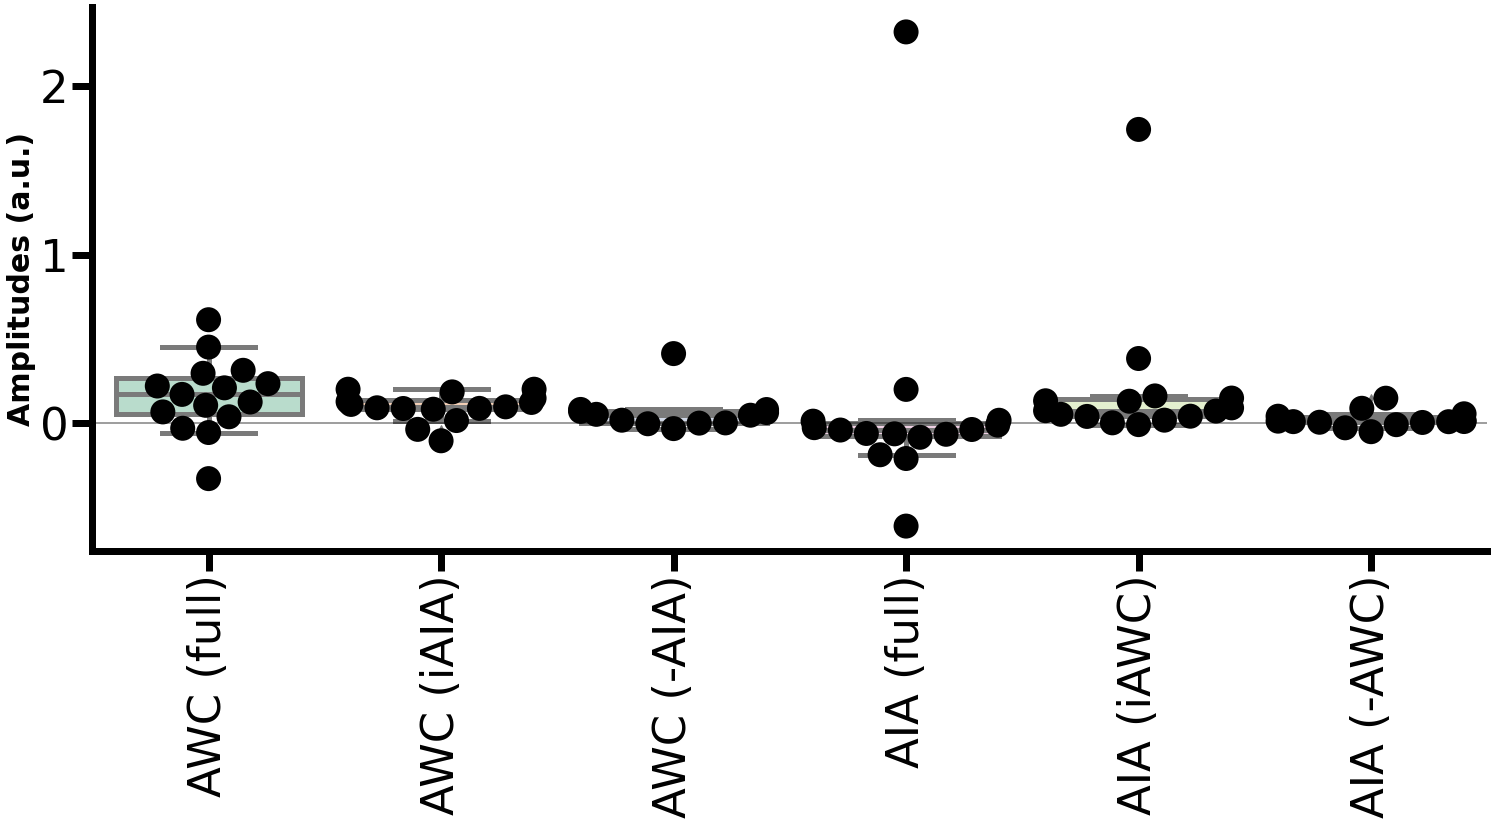

In [61]:
## Plotting Amplitudes or Offsets for Comparison ##
# Just showing amplitudes for simplicity, feel free to plot any/all combos.
# Note that if you want to plot WT vs non-WT data together (silenced), they have different n's. The way for me to 
# plot them together is to pad the shorter datasets with nans (nans don't get plotted).

data = np.array([ WT_dx_AWC_amp, WT_iAIA_dx_AWC_amp, noAIA_dx_AWC_amp+([np.nan]*3), 
                 WT_dx_AIA_amp, WT_iAWC_dx_AIA_amp, noAWC_dx_AIA_amp+([np.nan]*1)])
labels = ['AWC (full)', 'AWC (iAIA)', 'AWC (-AIA)', 'AIA (full)',  'AIA (iAWC)', 'AIA (-AWC)']

dF_amps = pd.DataFrame(data.T, columns=labels)
print(dF_amps)

colors = sns.color_palette("Pastel2")

fig, ax = plt.subplots(1,1, figsize=(25,10), facecolor='w')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 7
sns.boxplot(data=dF_amps,linewidth = 5, palette = colors)
sns.swarmplot(data=dF_amps, size=25, color = 'black')
#sns.swarmplot(data=dr_amps.loc[[2]], size=25, color='red') # uncomment to highlight
# specific traces shown in paper: worm index 2 for WT, 2 for -AWC, 11 for -AIA
plt.xticks(rotation=90)
plt.axhline(y=0, color='black', alpha=0.5)
ax.set_ylabel('Amplitudes (a.u.)', fontsize=30, weight='bold')
ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    

In [24]:
## Statistics ##

from scipy.stats import mannwhitneyu 
# mann-whitney U is for unpaired samples (between WT and HisCl (silenced) exps)

from scipy.stats import wilcoxon 
# wilcoxon is for paired samples (across all WT models) -- only works with same-length datasets for this reason

def Stats_model(choice, sample1, sample2, name):
    
    if choice == 'wilcoxon':
        new_array = []
        for i in range(len(sample1)):
            diff = sample1[i] - sample2[i]
            rounded = np.round(diff, decimals=2) # * this was suggested by scipy.wilcoxon documentation
            new_array.append(rounded)
        w = wilcoxon(new_array, y=None)
        p = w.pvalue
    if choice == 'mannwhitney':   
        U, p = mannwhitneyu(sample1, sample2)
    
    if p < 0.001:
        print(name, '***', p)
    elif p < 0.01:
        print(name, '**', p)
    elif p < 0.05:
        print(name, '*', p)
    elif p > 0.05:
        print(name, 'NS', p)
        
    return p

# Will just display residuals between WT full and WT ignored models for simplicity #

p1 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_sum_res, 'AVA-only vs AVA+AWC+AIA')
p2 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_slide_res, 'AVA-only vs Slide')
p3 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_dx_res, 'AVA-only vs Dx')
p4 = Stats_model('wilcoxon', WT_sum_res, WT_slide_res, 'AVA+AWC+AIA vs Slide')
p5 = Stats_model('wilcoxon', WT_sum_res, WT_dx_res, 'AVA+AWC+AIA vs Dx')
p6 = Stats_model('wilcoxon', WT_slide_res, WT_dx_res, 'Slide vs Dx')

AVA-only vs AVA+AWC+AIA ** 0.001410512473214279
AVA-only vs Slide *** 6.103515625e-05
AVA-only vs Dx *** 6.103515625e-05
AVA+AWC+AIA vs Slide *** 6.103515625e-05
AVA+AWC+AIA vs Dx ** 0.0014057202057531713
Slide vs Dx ** 0.0013120923163894367


/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [25]:
## Holm-Bonferroni Correction of Residuals ##
# This is a multiple comparison test between all p-values to correct for any potential statistical errors and
# false significance. This returns new, adjusted p-values based on the provided group of tests (ie all the WT exps)
# Bonferroni is a more stringent test, and Holm is a variation that is more tailored to your data.
# Because of this, you want to group your comparisons in a meaningful way (ie all ignored together to see which 
# ignored scenario is statistically different, or compare all AWC-silenced/ignored scenarios, or compare all WT
# scenarios, etc.)

import statsmodels.stats.multitest as multi

WT_pvals = [p1, p2, p3, p4, p5, p6]
hb1 = multi.multipletests(WT_pvals, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)
# Displays True/False statements of significance, followed by new corrected p values.
print(hb1)

for p in hb1[1]:
    if p < 0.001:
        print('***', p)
    elif p < 0.01:
        print('**', p)
    elif p < 0.05:
        print('*', p)
    elif p > 0.05:
        print('NS', p)

(array([ True,  True,  True,  True,  True,  True]), array([0.00393628, 0.00036621, 0.00036621, 0.00036621, 0.00393628,
       0.00393628]), 0.008512444610847103, 0.008333333333333333)
** 0.003936276949168311
*** 0.0003662109375
*** 0.0003662109375
*** 0.0003662109375
** 0.003936276949168311
** 0.003936276949168311


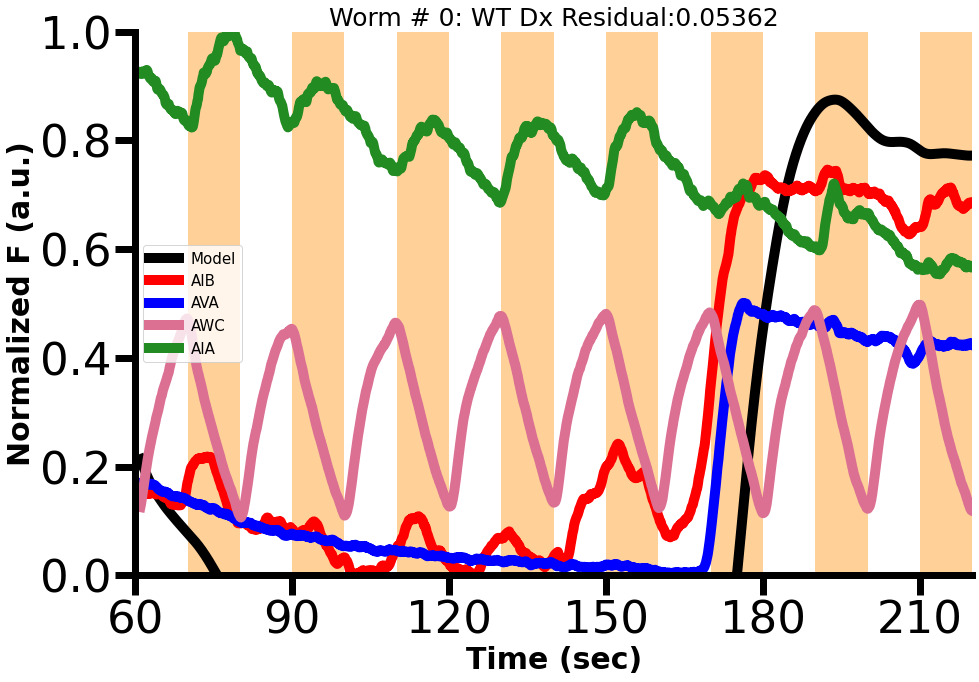

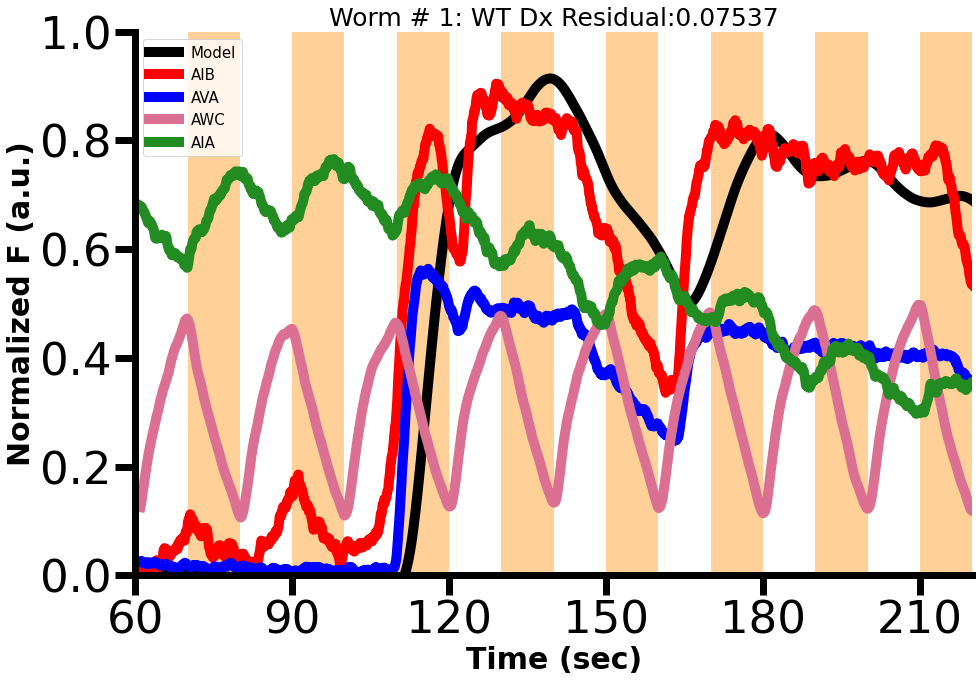

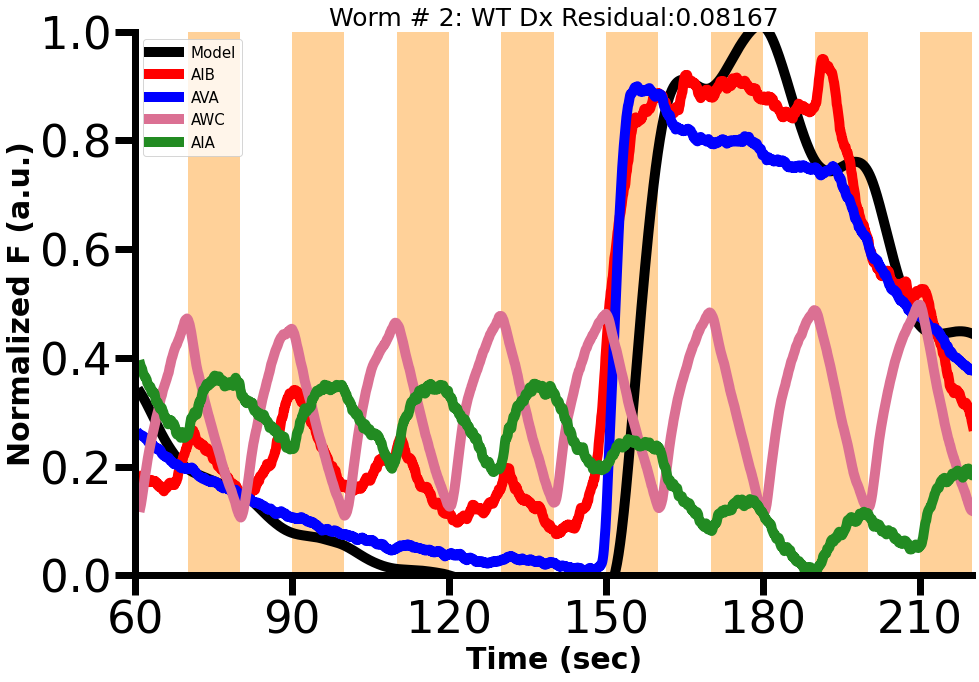

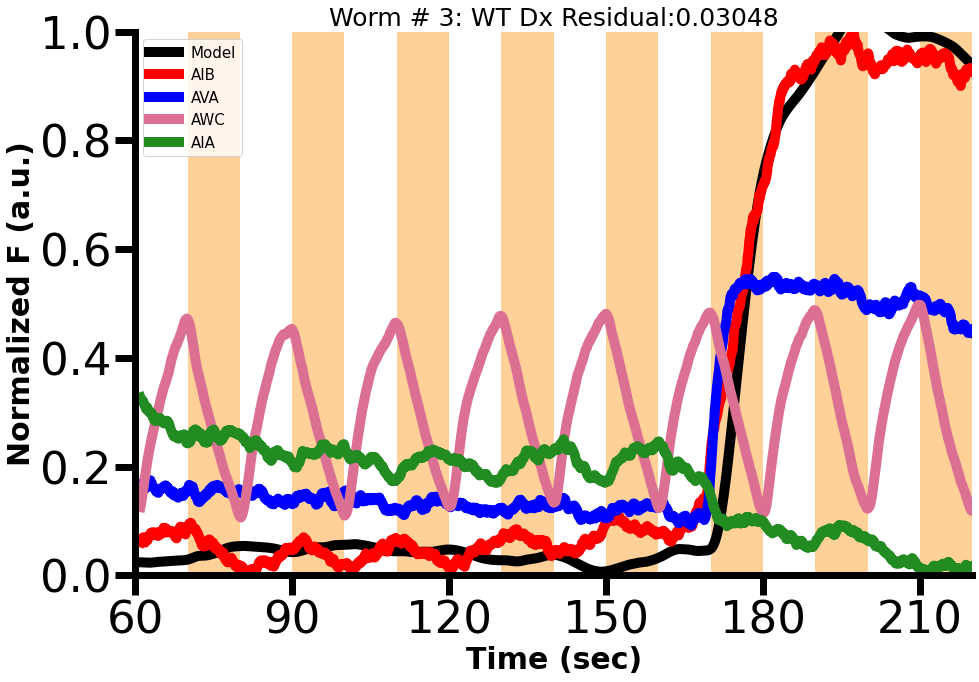

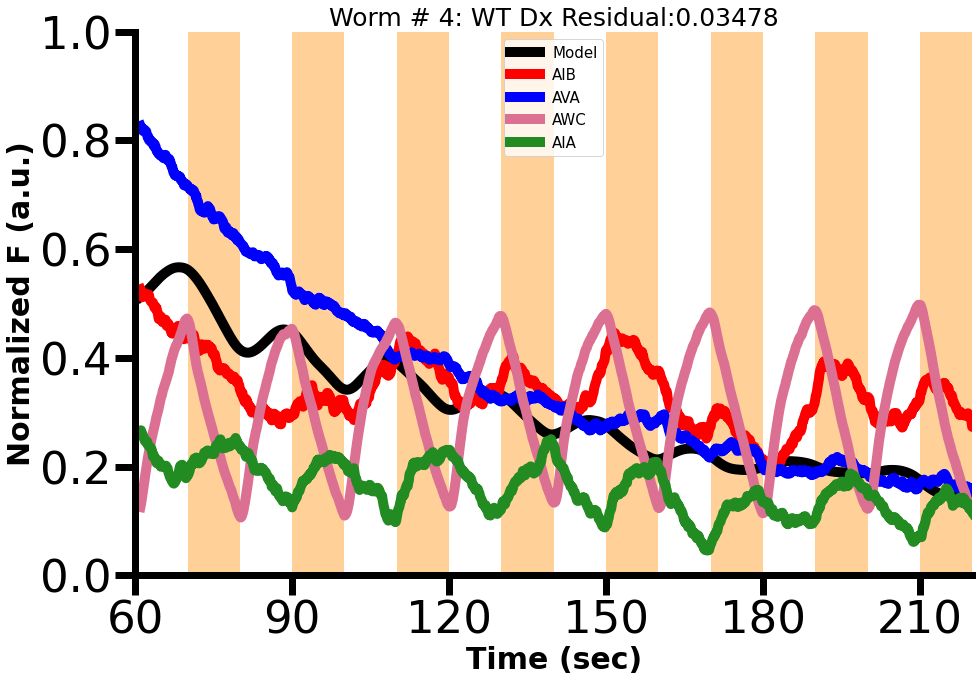

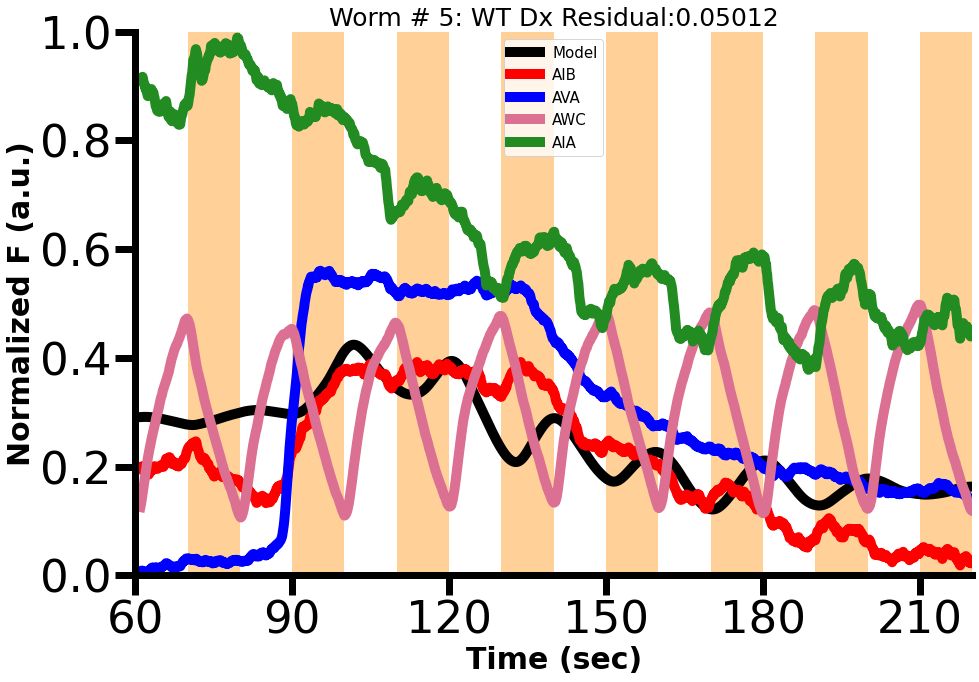

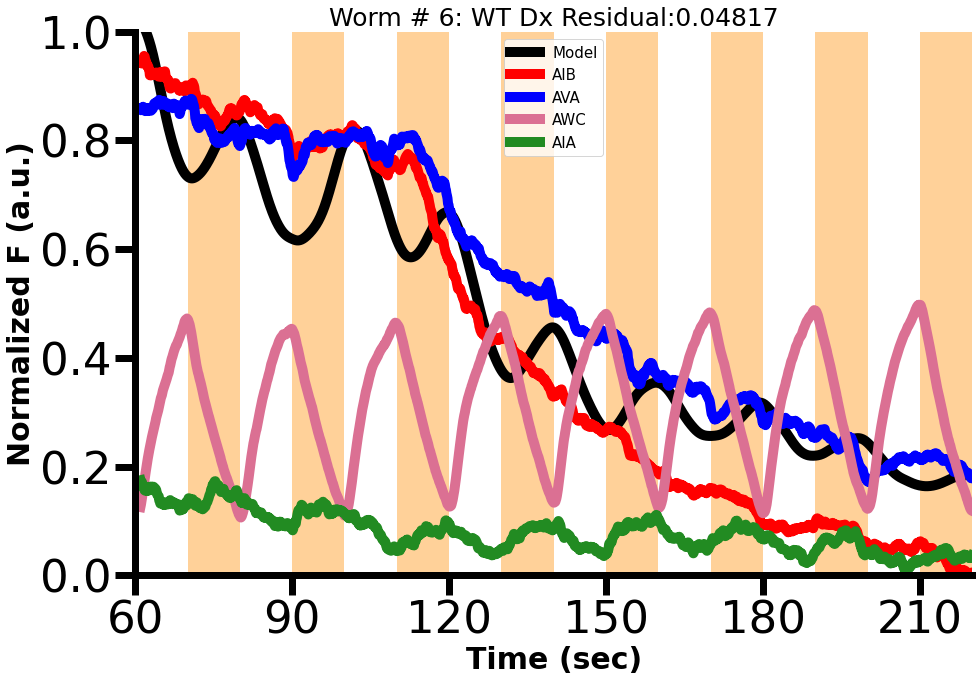

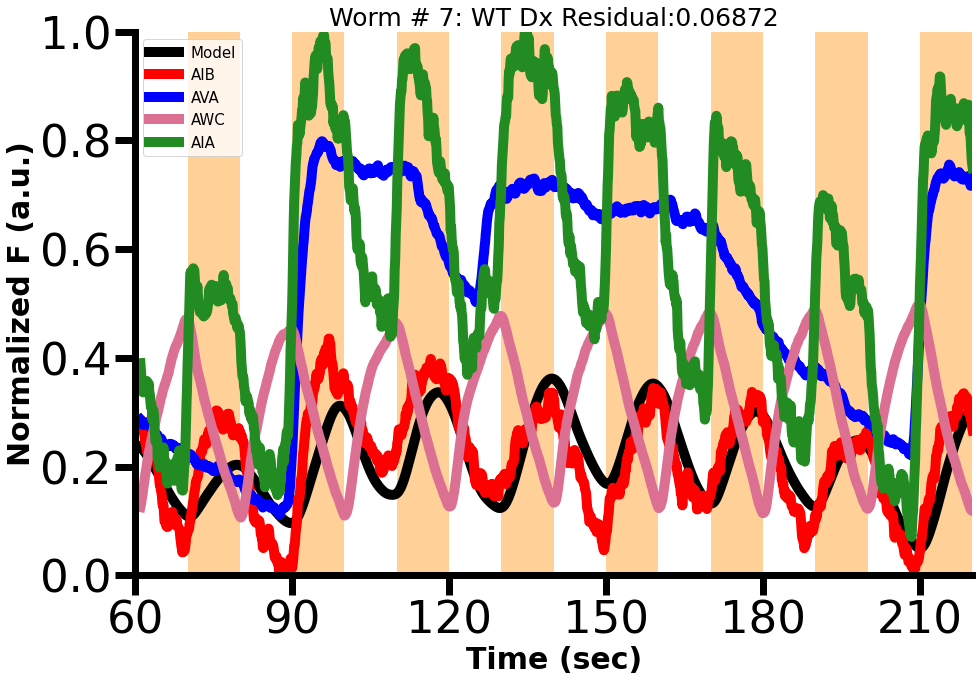

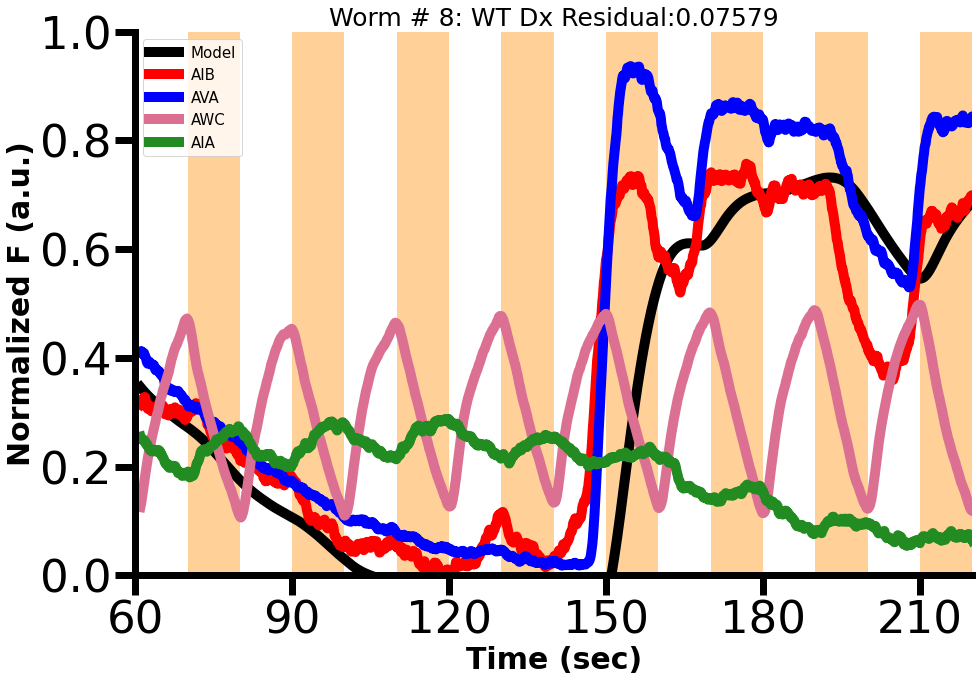

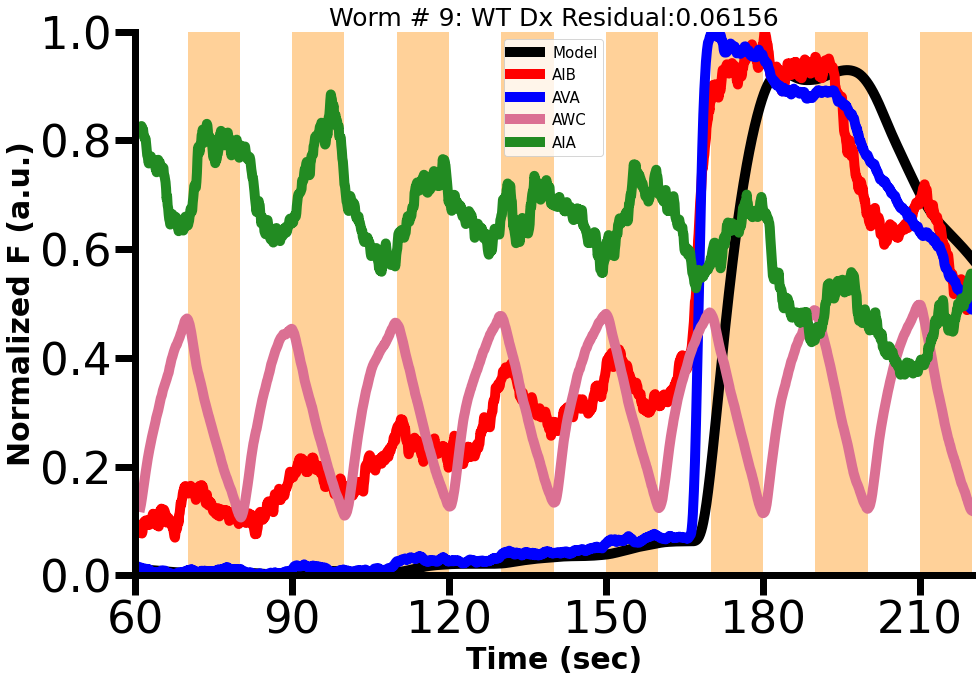

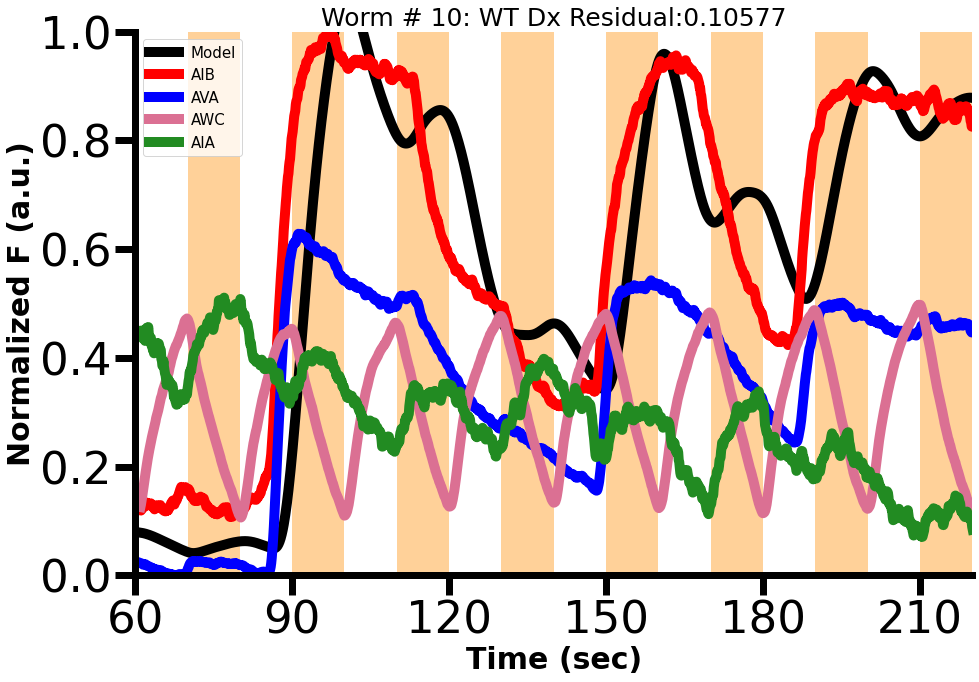

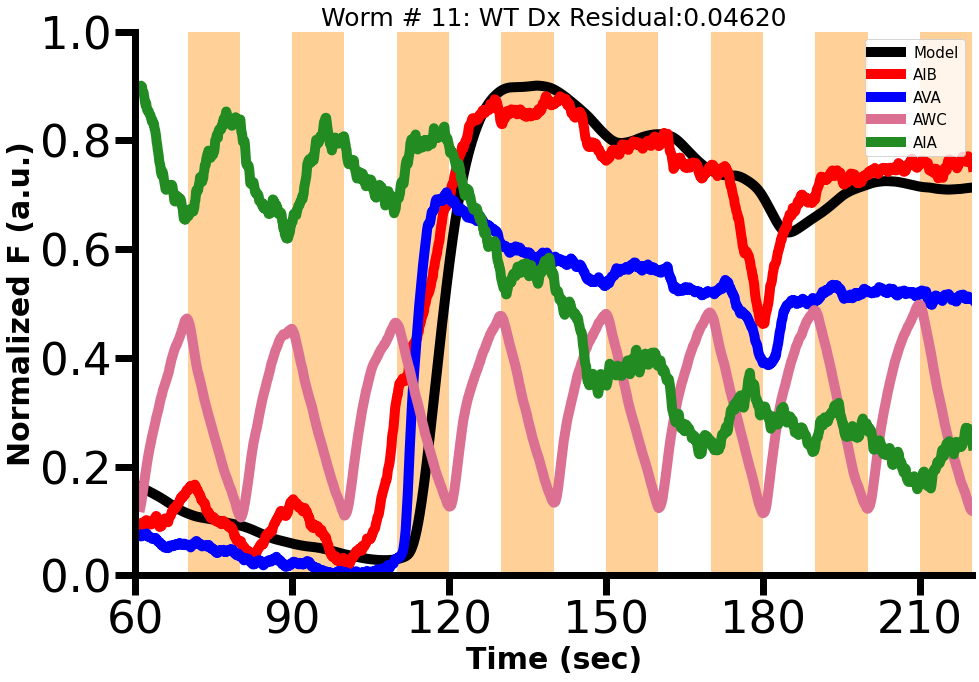

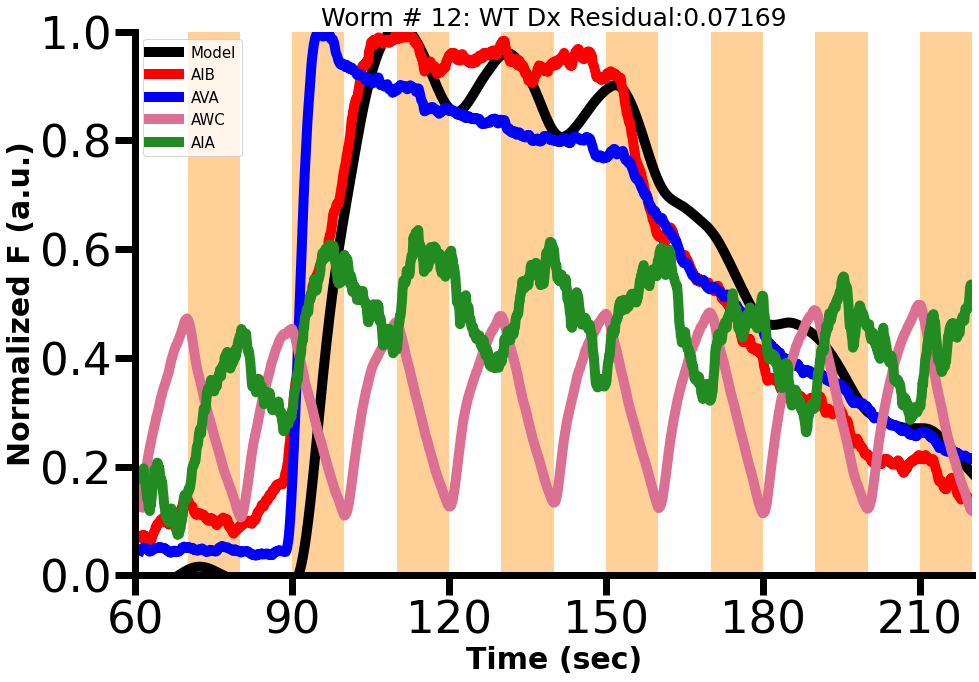

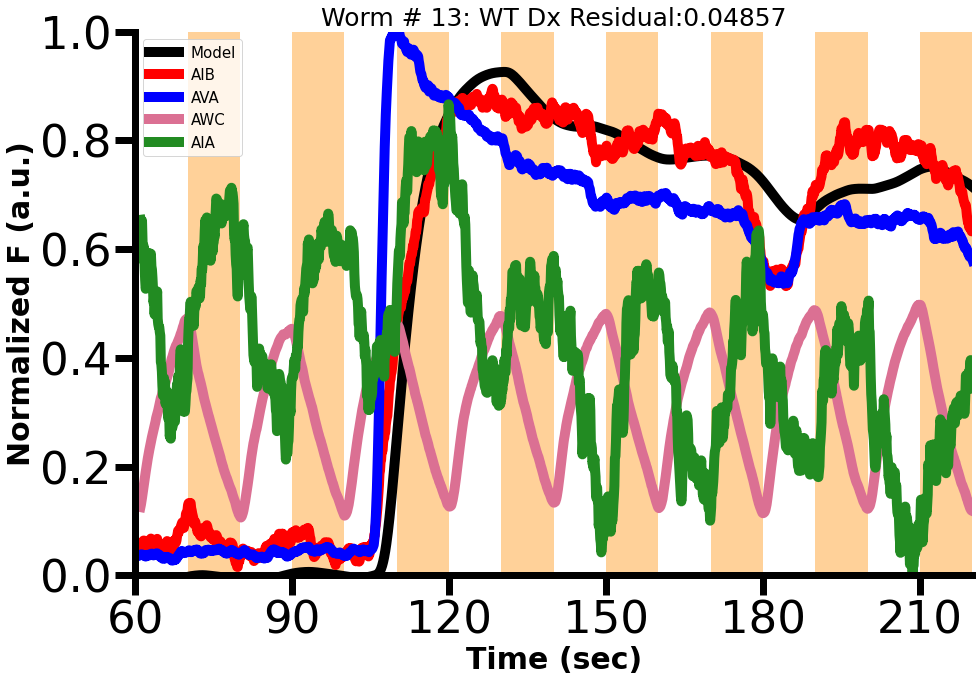

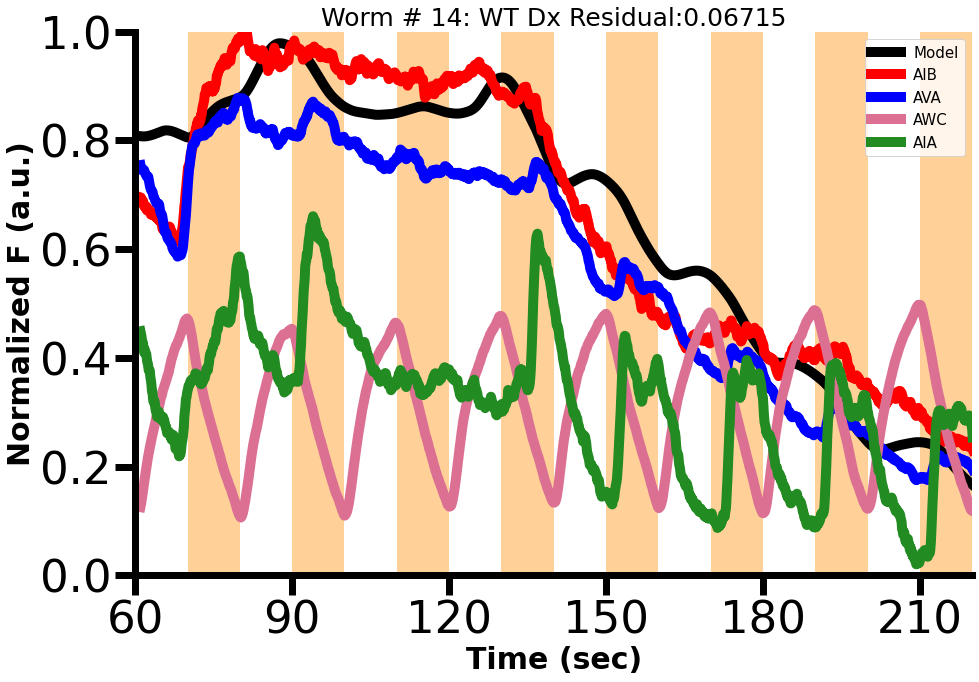

In [14]:
## - Plotting Traces and Model - ##
# Will just show odor+red light experiments as examples. 
# Note that when plotting normalized neuron traces with model, that the modeling process cuts off the first
# 249 frames, so to align neuron traces with model trace, need to cut off neuron trace AIB[249:]


# Easier to change between worms/exps this way
worm_num = WT_worm_num #15 for WT, 12 for ins_hiscl, 20 for nmr_hiscl
residual_plot = WT_dx_res
model_plot = WT_dAIA_models
aib_plot = WT_AIB_both 
ava_plot = WT_AVA_both
awc_plot = WT_AWC_both_avg
aia_plot = WT_AIA_both
title_name = 'WT Dx'


# This is to plot in seconds (10 fps). Sort of complicated, but normalization cuts off 350 frames in beginning, 
# and convolution process cuts off an additional 249 frames (time window - 1) in beginning, totaling 599 frames. 
# I rounded it up to 600, and added the extra 1 frame shift to the end for simplicity, because I cut off the
# last 90 frames. There is originally a total of 2300 frames, but the smoothing process (5 frames x2) cuts off 10,
# so new length is 2290 (plus the 1 extra frame shift I added to help round the beginning). Thus, 600,2291.
# This is all just for publication and for transparency of where the ACTUAL time starts in my raw traces.
# Feel free to change to time that makes more sense lol :) 

# Numbers here add shift to match dAVA modeling (truncated by 10 frames at beginning and end)
shift = 10

timeplot = []
for t in range(600+shift,2291-shift): 
    temp = t/10
    timeplot.append(temp)

for i in range(worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') 
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax.set_title('Worm # '+str(i) + ': '+ title_name + ' Residual:'+str(residual_plot[i])[:7], fontsize=25)
    ax.plot(timeplot, model_plot[i], color = 'black', linewidth=10, label='Model')
    ax.plot(timeplot, aib_plot[i][249+shift:-shift], color = 'red', linewidth=10, alpha=1, label='AIB') 
    ax.plot(timeplot, ava_plot[i][249+shift:-shift], color = 'blue', linewidth=10, alpha=1, label='AVA') 
    ax.plot(timeplot, awc_plot[i][249+shift:-shift], color = 'palevioletred', linewidth=10, alpha=1, label='AWC') 
    ax.plot(timeplot, aia_plot[i][249+shift:-shift], color = 'forestgreen', linewidth=10, alpha=1, label='AIA') 
    ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax.set_ylabel('Normalized F (a.u.)', fontsize=30, weight='bold')
    ax.set_xlabel('Time (sec)', fontsize=30, weight='bold')
    ax.set_ylim([0,1])
    ax.set_xlim([60,220])
    ax.legend(loc='best', fontsize=15)
    plt.xticks(np.arange(60, 220, step=30))
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    # If you want to color-code stimuli delivery times, use code below or comment out if don't want
    
    for j in range(0,22): #0,16
        if j % 2 != 0:
            start = j*10
            stop = (j*10)+10
            ax.axvspan(start, stop, facecolor='darkorange', alpha=0.4) 
            ## odor_color = yellow 
            ## redlight_color = crimson 
            ## both_color = darkorange
            
    #plt.savefig(title_name + '.svg')

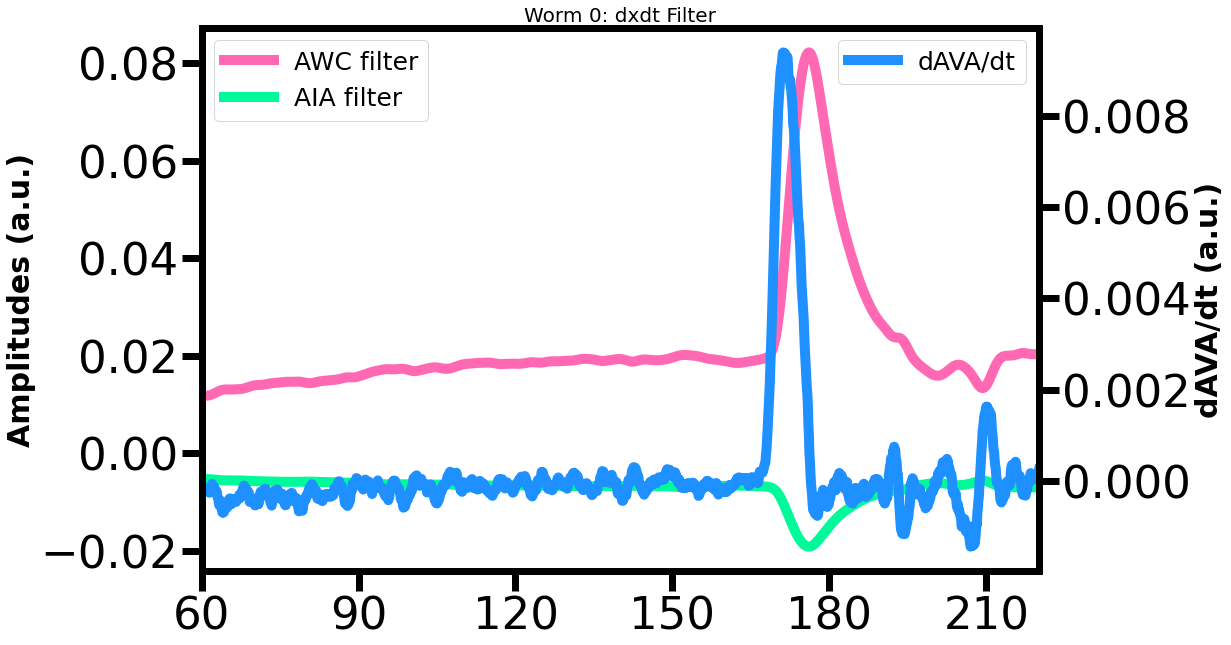

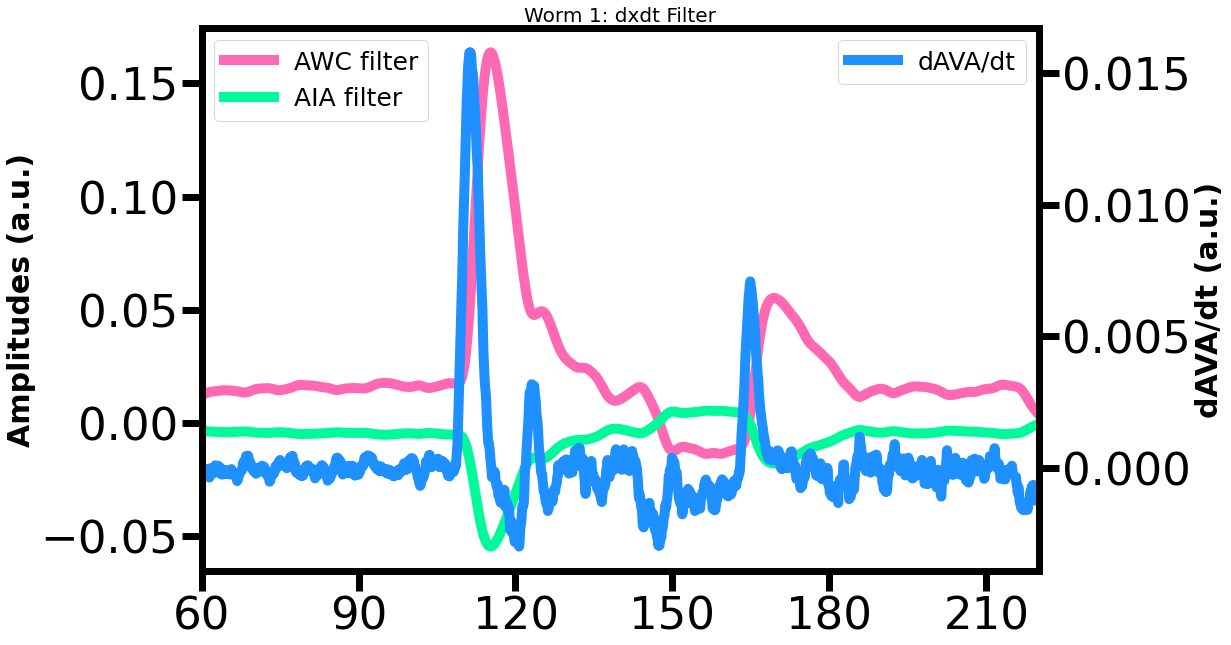

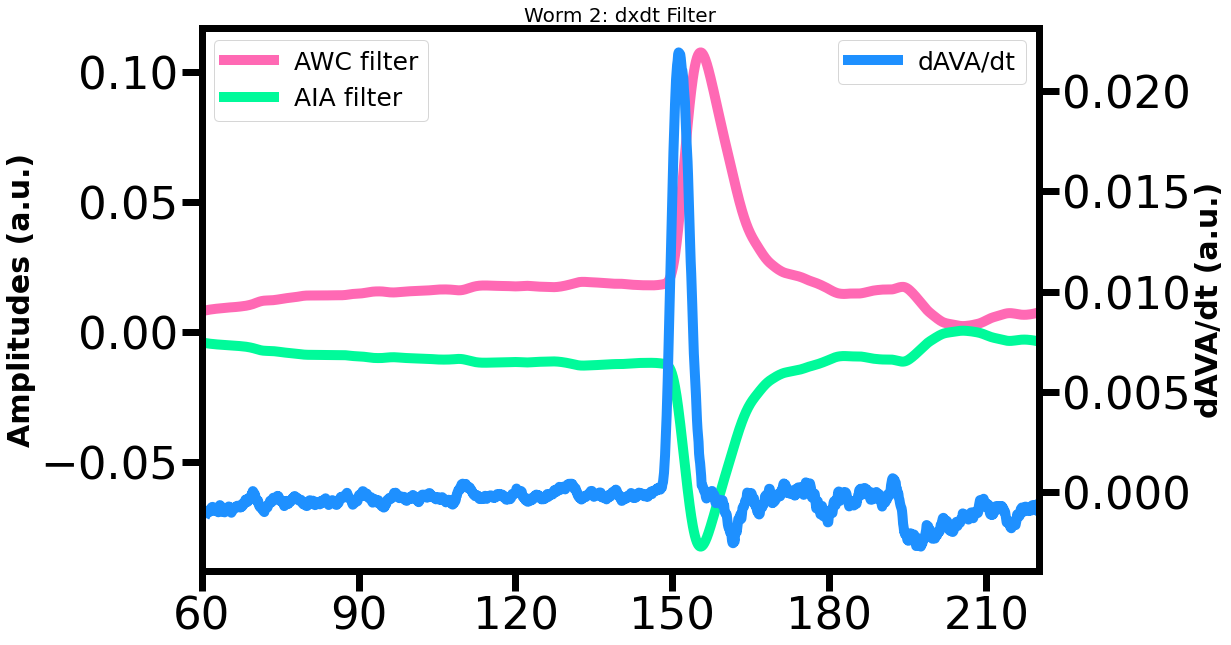

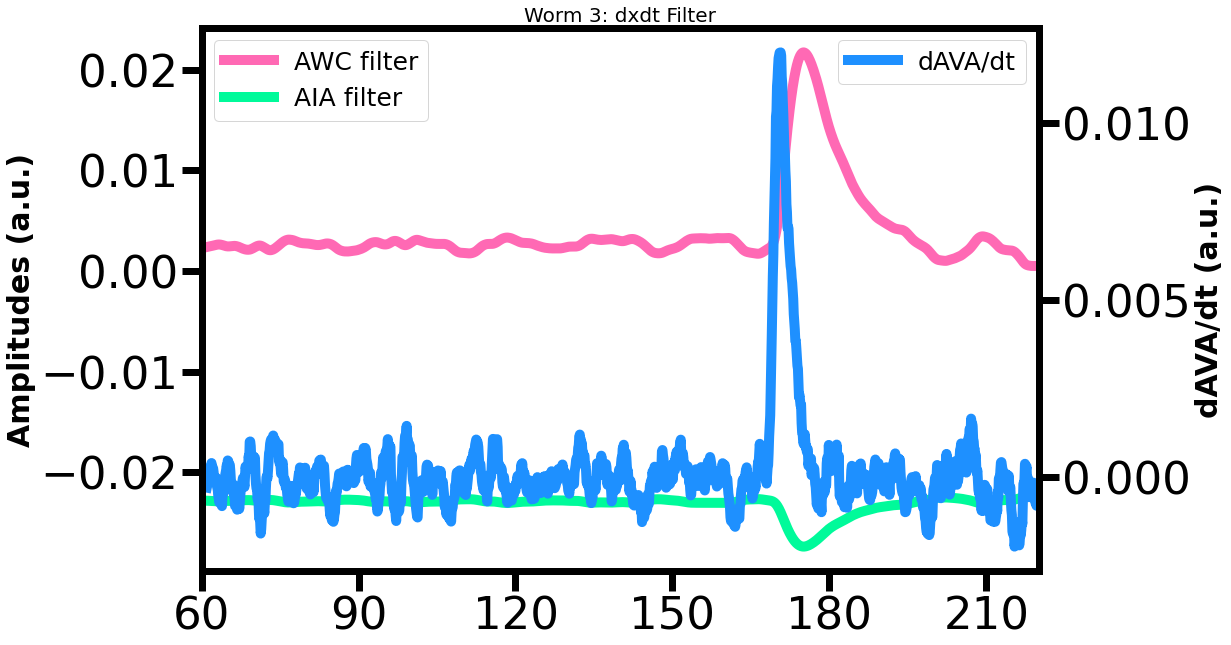

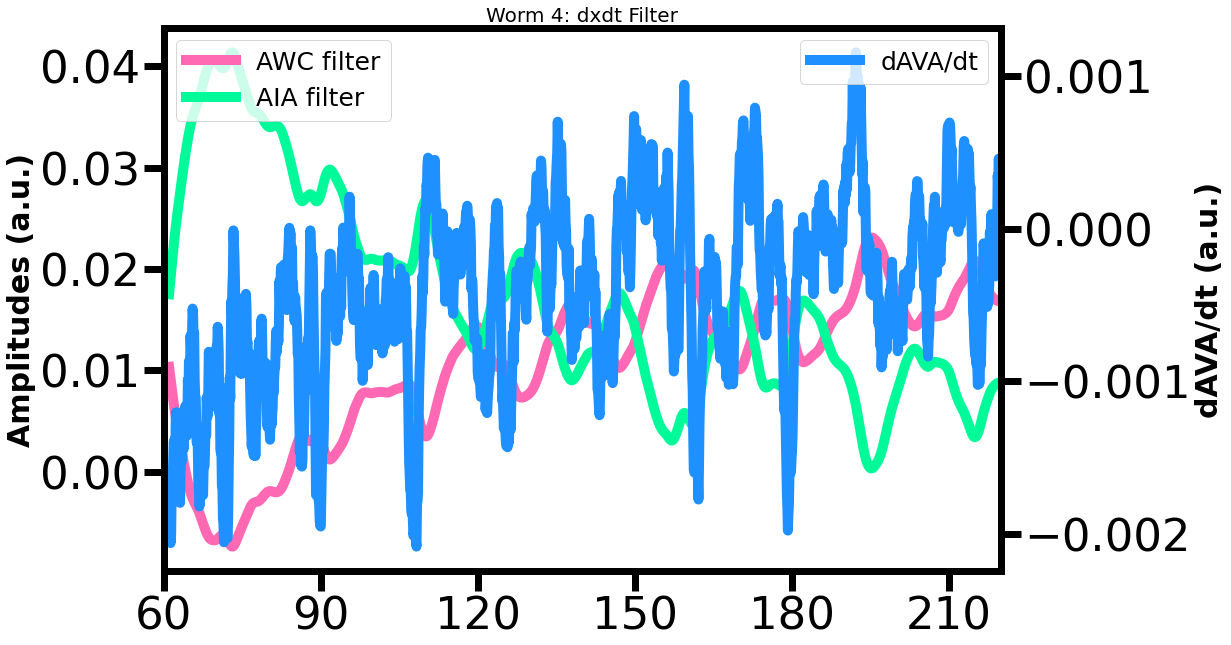

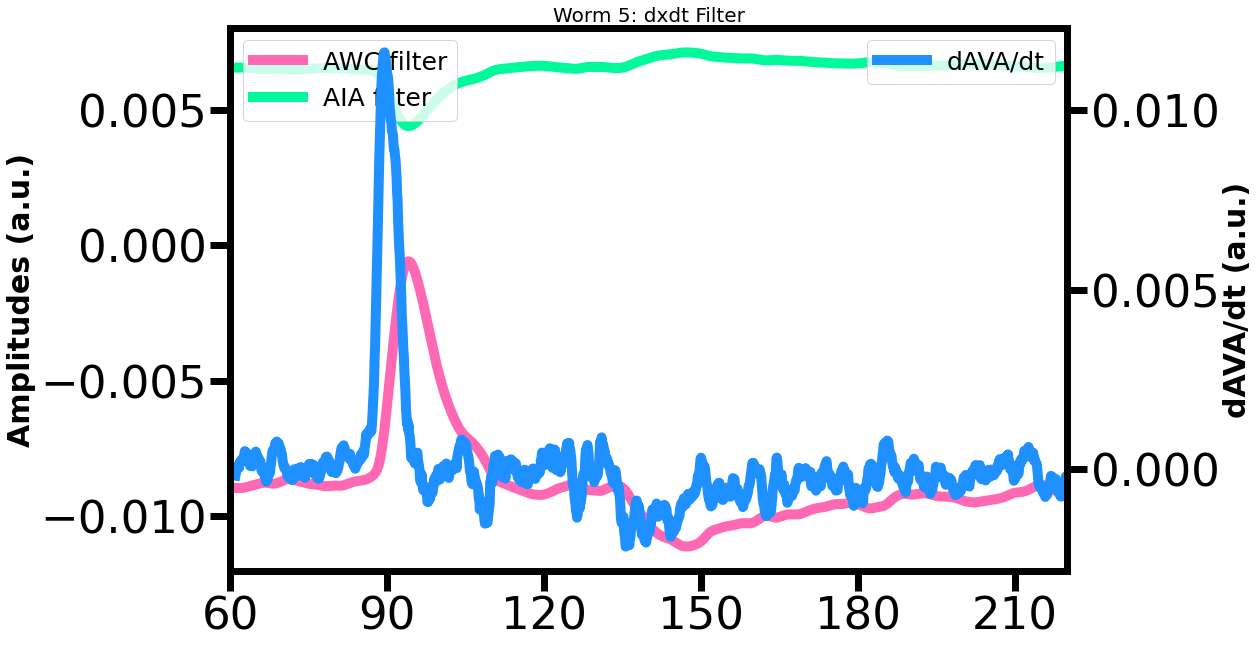

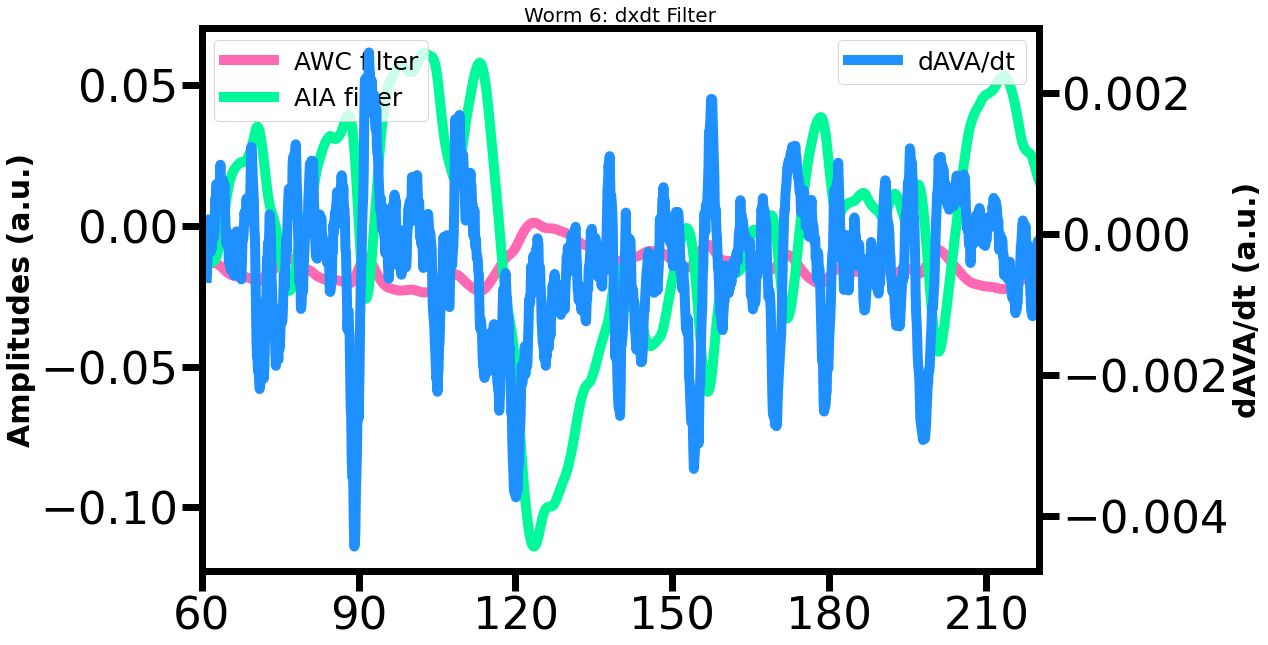

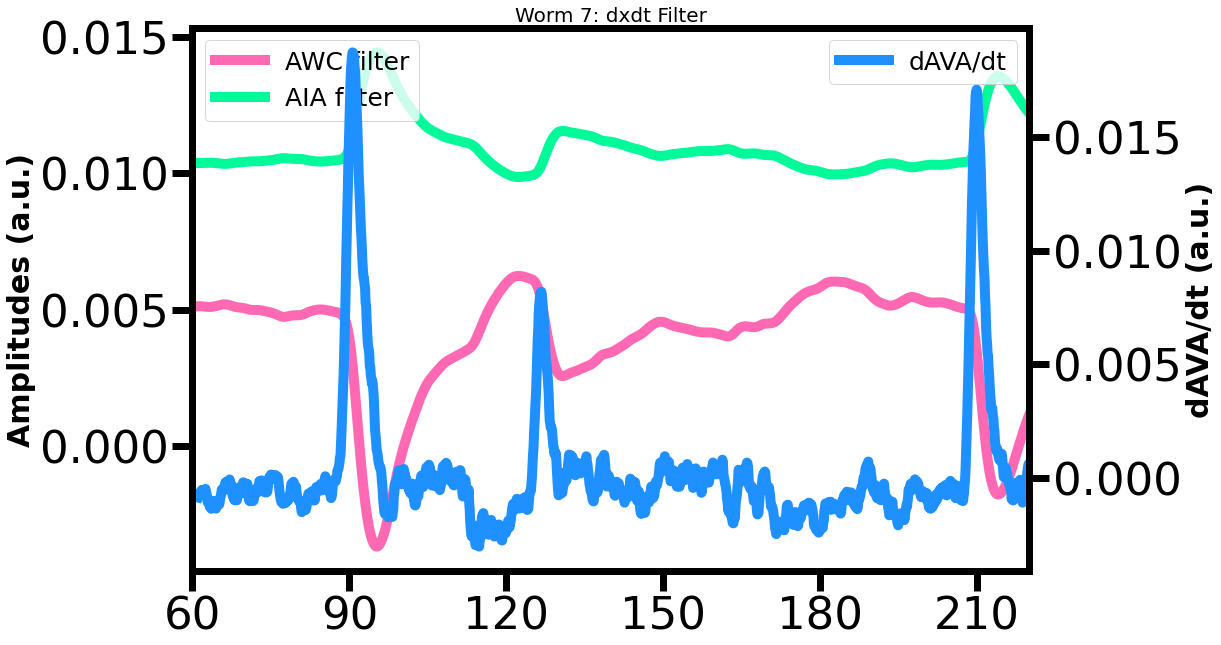

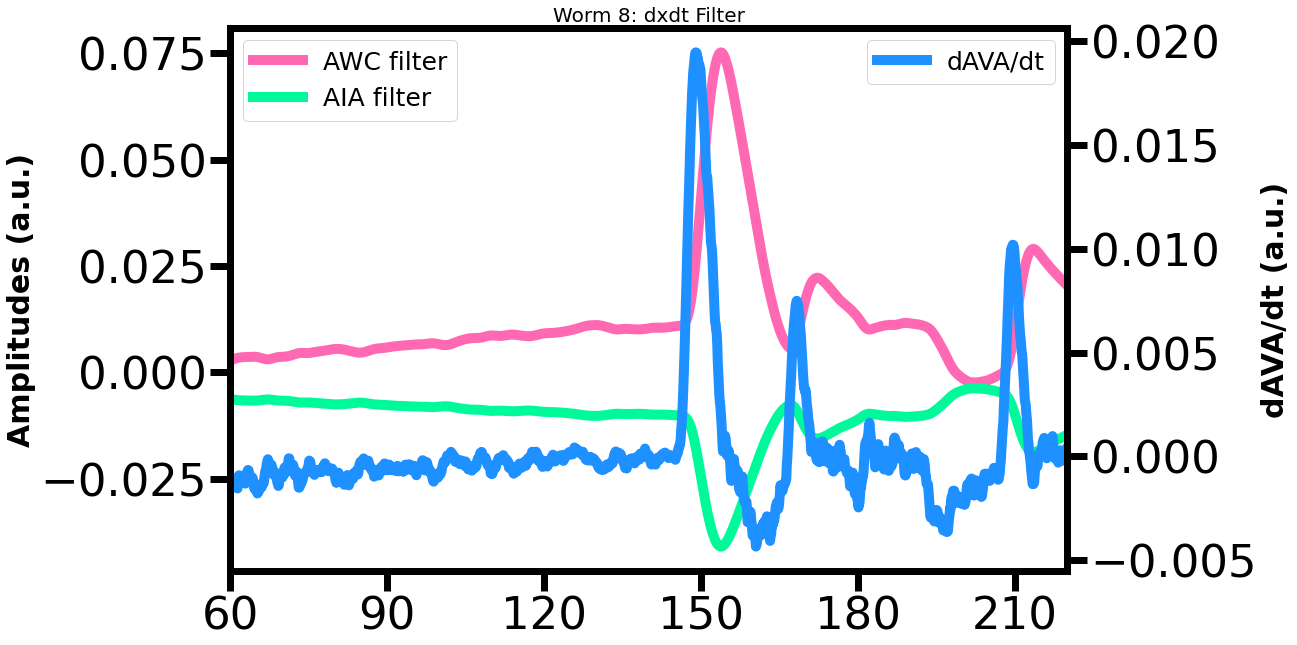

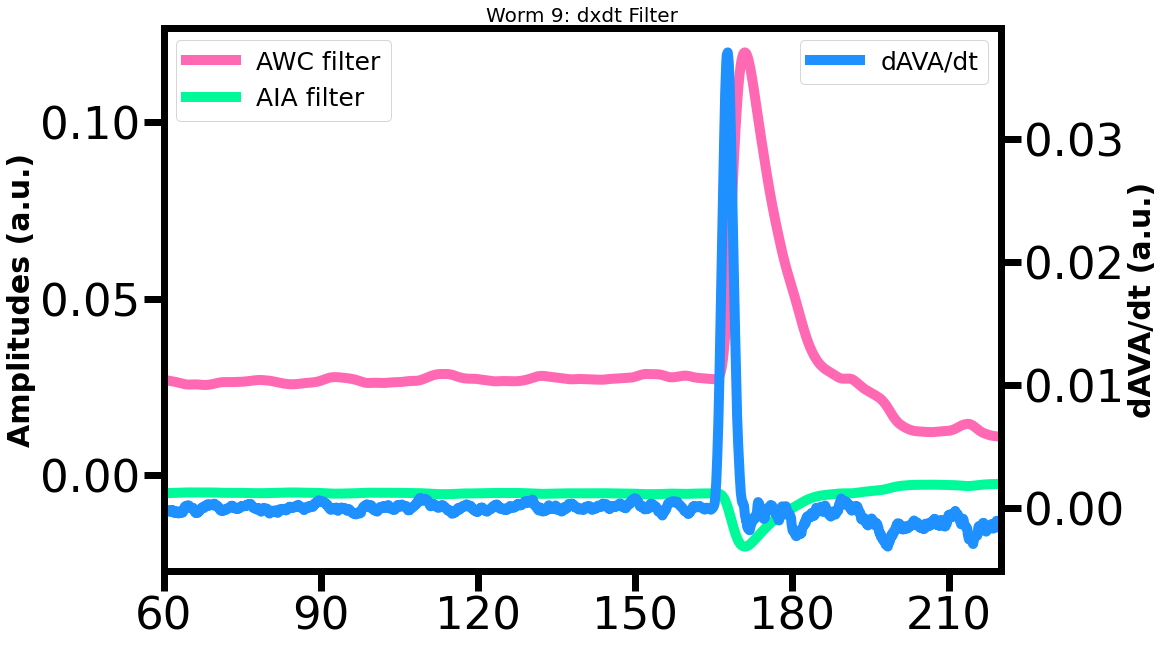

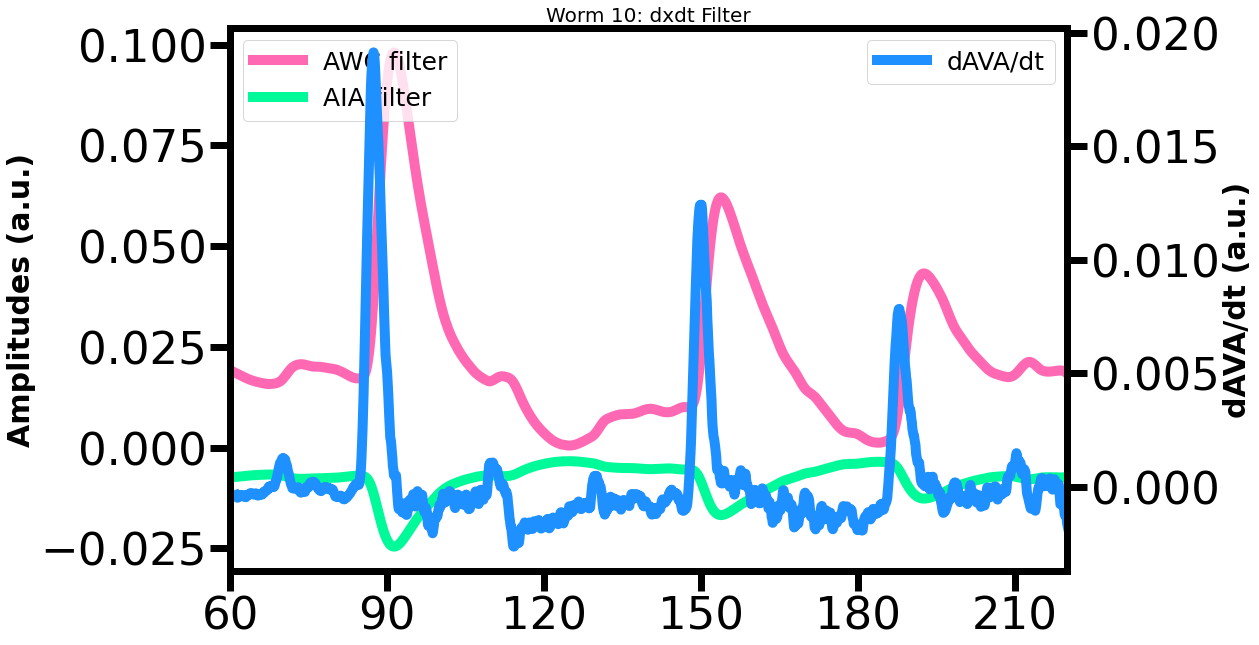

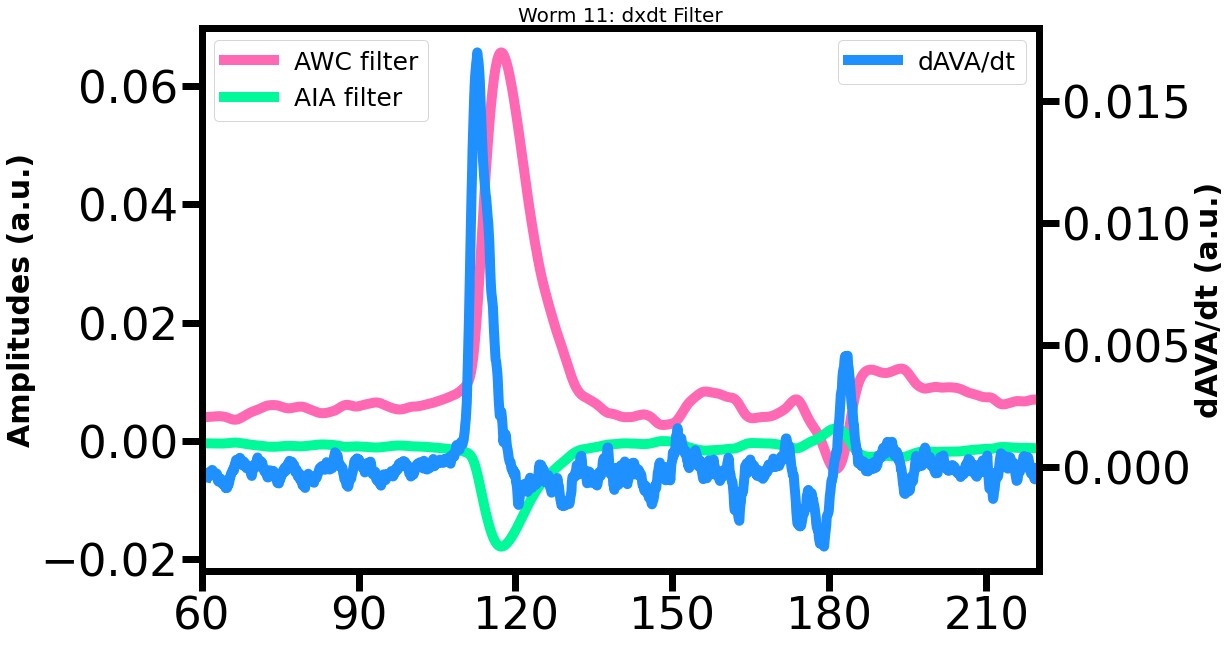

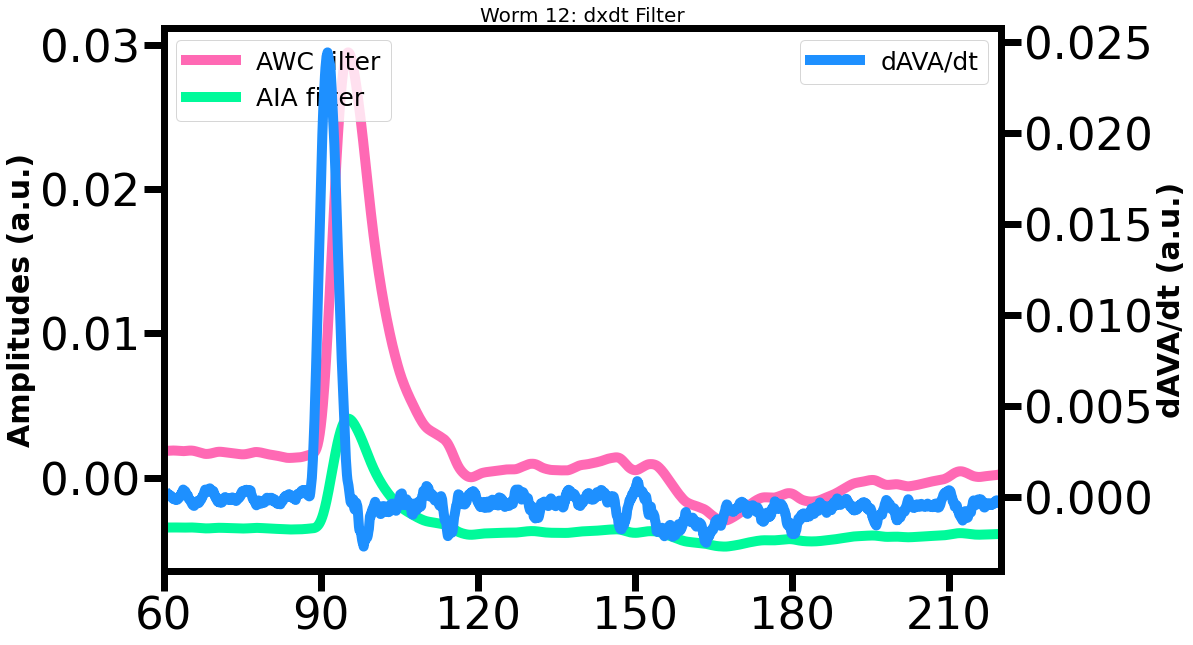

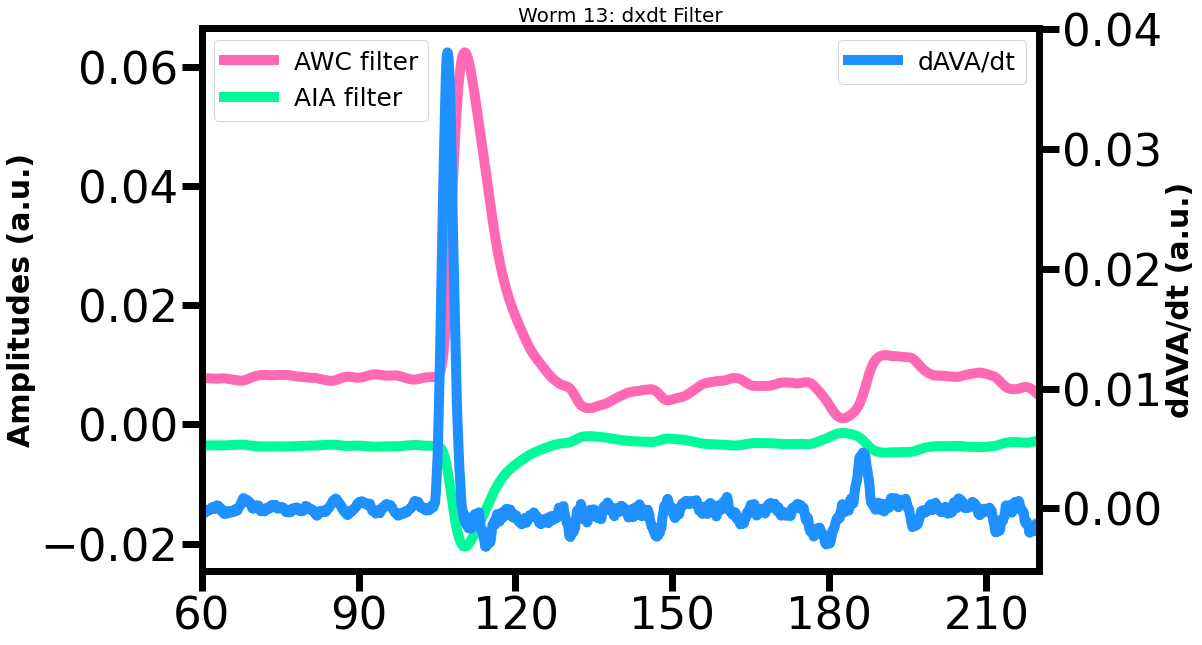

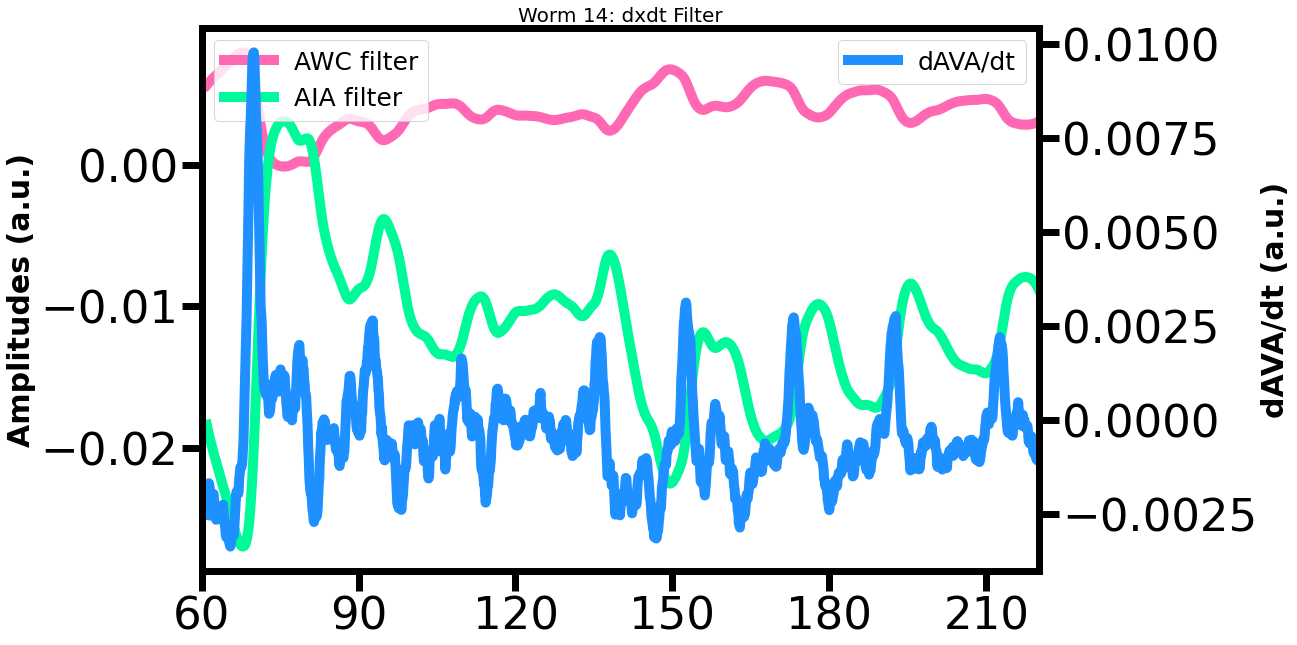

In [65]:
## - Plotting - Amplitude filters - ##

# This is basically what the AWC and AIA amplitudes look like as they're being convolved with dAVA/dt.
# These would be the resulting fits shown for each amplitude. They represent the sensory inputs as they're being
# filtered by AVA activity changes. 
    
def Filters_dxdt(amp, offset, alpha1_input, alpha2_input, dAVA, worm_num): # input resulting amps and offsets
    time = 250 # kernel time window, we found 250 frames to be a good time period
    t = np.arange(0, time)
    
    amp_filter = []
    
    for i in range(worm_num): # basically have to re-convolve it to dAVA based on resulting fit amps and offsets 
        kernel = amp[i] * (np.exp(-alpha1_input*t) - np.exp(-alpha2_input*t)) 
        amp_conv = np.convolve(dAVA[i], kernel, 'same') + offset[i]
        amp_filter.append(amp_conv)
        
    return amp_filter
    
# WT #    
WT_dxdt_AWC_filt = Filters_dxdt(WT_dx_AWC_amp, WT_dx_AWC_offset, WT_AVA_only_params['Alpha1 Both'], 
                                WT_AVA_only_params['Alpha2 Both'], WT_dAVA_both, WT_worm_num)

WT_dxdt_AIA_filt = Filters_dxdt(WT_dx_AIA_amp, WT_dx_AIA_offset, WT_AVA_only_params['Alpha1 Both'], 
                                WT_AVA_only_params['Alpha2 Both'], WT_dAVA_both, WT_worm_num)
        
# AWC ignore/silence #
WT_iAWC_dxdt_AIA_filt = Filters_dxdt(WT_iAWC_dx_AIA_amp, WT_iAWC_dx_AIA_offset, WT_AVA_only_params['Alpha1 Both'], 
                                WT_AVA_only_params['Alpha2 Both'], WT_dAVA_both, WT_worm_num)
                                               
noAWC_dxdt_AIA_filt = Filters_dxdt(noAWC_dx_AIA_amp, noAWC_dx_AIA_offset, WT_AVA_only_params['Alpha1 Both'], 
                                WT_AVA_only_params['Alpha2 Both'], strHis_dAVA_red, strHis_worm_num)
                                
    
# AIA ignore/silence #
WT_iAIA_dxdt_AWC_filt = Filters_dxdt(WT_iAIA_dx_AWC_amp, WT_iAIA_dx_AWC_offset, WT_AVA_only_params['Alpha1 Both'], 
                                WT_AVA_only_params['Alpha2 Both'], WT_dAVA_both, WT_worm_num)
                                
noAIA_dxdt_AWC_filt = Filters_dxdt(noAIA_dx_AWC_amp, noAIA_dx_AWC_offset, WT_AVA_only_params['Alpha1 Both'], 
                                WT_AVA_only_params['Alpha2 Both'], insHis_dAVA_odor, insHis_worm_num)


# makes it easier to switch plotting between experiments
worm_num = WT_worm_num
dAVA_plot = WT_dAVA_both
AWC_filter_plot = WT_dxdt_AWC_filt
AIA_filter_plot = WT_dxdt_AIA_filt 

timeplot = []
for e in range(610,2281): #0,1671 if you don't want shifted time
    temp = e/10
    timeplot.append(temp)

for i in range(worm_num):
    fig, ax1 = plt.subplots(1,1, figsize=(15,10), facecolor='w')
    ax2 = ax1.twinx()
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax1.set_title('Worm ' +str(i)+': dxdt Filter', fontsize=20)
    ax2.plot(timeplot, dAVA_plot[i][249:], color='dodgerblue', linewidth = 10, alpha=1, label='dAVA/dt') 
    ax1.plot(timeplot, AWC_filter_plot[i][125:-124], color='hotpink', linewidth = 10, alpha=1, label='AWC filter')
    ax1.plot(timeplot, AIA_filter_plot[i][125:-124], color='mediumspringgreen', linewidth = 10, alpha=1, label='AIA filter')
    #'valid' mode of convolution cuts off beginning 249, 'same' cuts off half of beginning and half end 125:-124
    ax2.legend(loc='upper right', fontsize=25)
    ax1.legend(loc='upper left', fontsize=25)
    ax2.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax1.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax2.set_ylabel('dAVA/dt (a.u.)', fontsize=30, weight='bold')
    ax1.set_ylabel('Amplitudes (a.u.)', fontsize=30, weight='bold')
    plt.xticks(np.arange(60, 220, step=30))
    ax2.set_xlim([60,220]) #0, 140
    #ax1.set_ylim([-0.1,0.15])
    ax2.set_xlabel('Time (sec)', fontsize=30, weight='bold')